In [2]:
%run init_notebookspace.py
from settings import *

## Table of Content
* [Introduction](#chapter0)
* [Get Italy data](#chapter1)
* [Preprocessing the data](#chapter2)
    * [Train Test Split](#section_2_1)
    * [Log-Transformation of the Data](#section_2_2)
    * [Detrend the Data](#section_2_3)
    * [Deseasonalize the Data](#section_2_4)
        * [OLS method](#subsection_1)
        * [HP filter](#subsection_2)
* [Make RBC Model](#chapter3)
    * [Model Equations](#section_3_1)
    * [Find Steady State, Solve the Model](#section_3_2)
    * [Check Blanchard Kahn Conditions](#section_3_3)
* [Maximum Likelihood Estimation](#chapter4)
    * [A Simple Model](#section_4_1)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_1)
        * [Forecasting](#subsection_4_2)
    * [A Noisy Model](#section_4_2)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_3)
        * [Forecasting](#subsection_4_4)
    * [Adding Variables](#section_4_3)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_5)
        * [Forecasting](#subsection_4_6)
    * [Final Model](#section_4_4)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_7)
        * [Forecasting](#subsection_4_8)
    * [Impulse response](#section_4_5)
        * [New Steady State](#subsection_4_9)

## Introduction <a class="anchor" id="chapter0"></a>

The aim of this paper is to fit the RBC model for Italy. 
The source of all the data is the National Institute of Statistics of Italy (ISTAT) and his database. 
The parameters use instead are taken from
1. the official site of the Bank of Italy (https://www.bancaditalia.it/compiti/ricerca-economica/modelli-macroeconomici/index.html?com.dotmarketing.htmlpage.language=1)
2.  Jerger, Jürgen; Röhe, Oke (2012) : Testing for Parameter Stability in DSGE Models. The Cases of France, Germany, Italy, and Spain, BGPE Discussion Paper, No. 118, Friedrich-Alexander-Universität Erlangen-Nürnberg, Bavarian Graduate Program in Economics (BGPE), Nürnberg 
3. Gottlieb, Onken, Valladares-Esteban (2021): On the Measurement of the Elasticity of Labour, European Economic Review, Volume 139, 103879, ISSN 0014-2921
4. Marino (2016) : The Italian productivity solwdown in a Real Business Cycle perspective, Int Rev Econ, 63, pages 171-193.


In [3]:
%matplotlib inline
import gEcon as ge
import gEcon.plotting as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az

import os
import statsmodels.api as sm
import statsmodels
import scipy

from src.utils import time_format, plot_df, get_seasonal_hp, arr_adf, apply_func, poly_detrend, ADF_test_summary, plot_sm_results
from src.utils import get_max_seasonal, OLS_dummie_deseasonal

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()
    pass

## Get Italy data <a class="anchor" id="chapter2"></a>

Once built a complete dataset in csv format, here we import series for consumption, investment, labor (in the form hours worked), GDP (at current prices, non deseasonalized), real interest rate , and wages (for non farm workers).

In [6]:
data = pd.read_csv(os.path.join(DATA_DIR, "all_rbc_data.csv"), infer_datetime_format="QS")
data["TIME"] = time_format(data.TIME)
data.set_index("TIME", drop=True, inplace=True)
data.sort_index(inplace=True)

# assign new column names
data.rename(columns=dict(zip(data.columns, ["Y", "I", "Z", "X", "r", "C", "w", "L"])), inplace=True)

# drop exports imports, not required
data.drop(["X", "Z"], axis=1, inplace=True)

In [7]:
glob_cols = list(data.columns)
plot_vars = ['A', 'C', 'I', 'L', 'Y', 'K', 'lambda', 'r', 'w']

## Prepocessing the Data <a class="anchor" id="chapter3"></a>

In this section more work on the data has been done; we have:
- split the data (as suggested) to have a train dataset to build the model and a test dataset to see if it works properly
- log linearized the variables
- detrend and deseasonalized the variables


In [8]:
# check for na
print(f"NaNs \n{data.isna().sum()}")

NaNs 
Y     0
I     0
r     0
C     0
w    36
L     0
dtype: int64


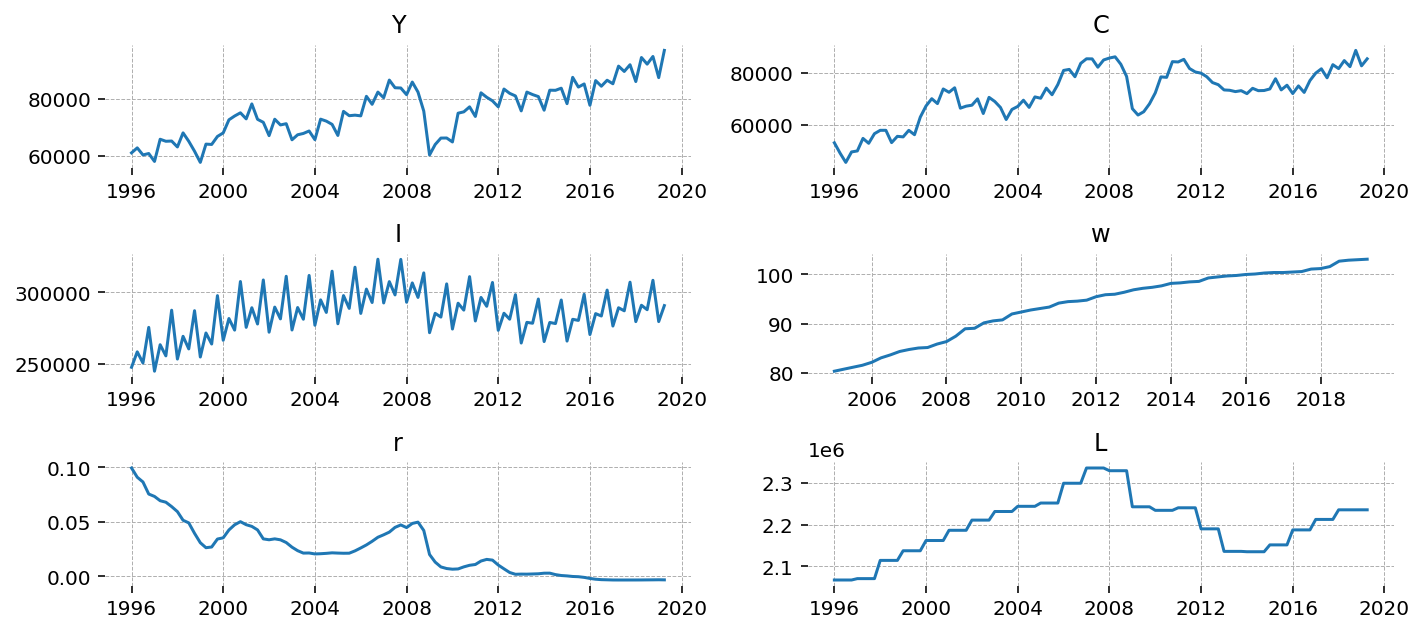

In [9]:
# raw data
plot_df(data)

### Train Test Split <a class="anchor" id="section_2_1"></a>

We are splitting data into a testing and training data set, which will follow the same preprossesing. It is important to note that all data specific transformations applied to 'test' are based on the training data.

In [10]:
test_size = 0.15
test_index = len(data.index) - round(len(data.index) * test_size)
test_size = len(data) - test_index
print(f"Test size: {test_size} \nTrain size: {test_index}")

Test size: 14 
Train size: 80


In [11]:
train = data.iloc[:test_index].copy()
test = data.iloc[test_index:].copy()

### Log-transformation of the Data <a class="anchor" id="section_2_2"></a>

In [12]:
# log transform
for col in [item for item in glob_cols if item != "r"]:
    train[col] = apply_func(train[col], func=np.log)
    test[col] = apply_func(test[col], func=np.log)

Raw data is log transformed, thus somehow equalised in scale

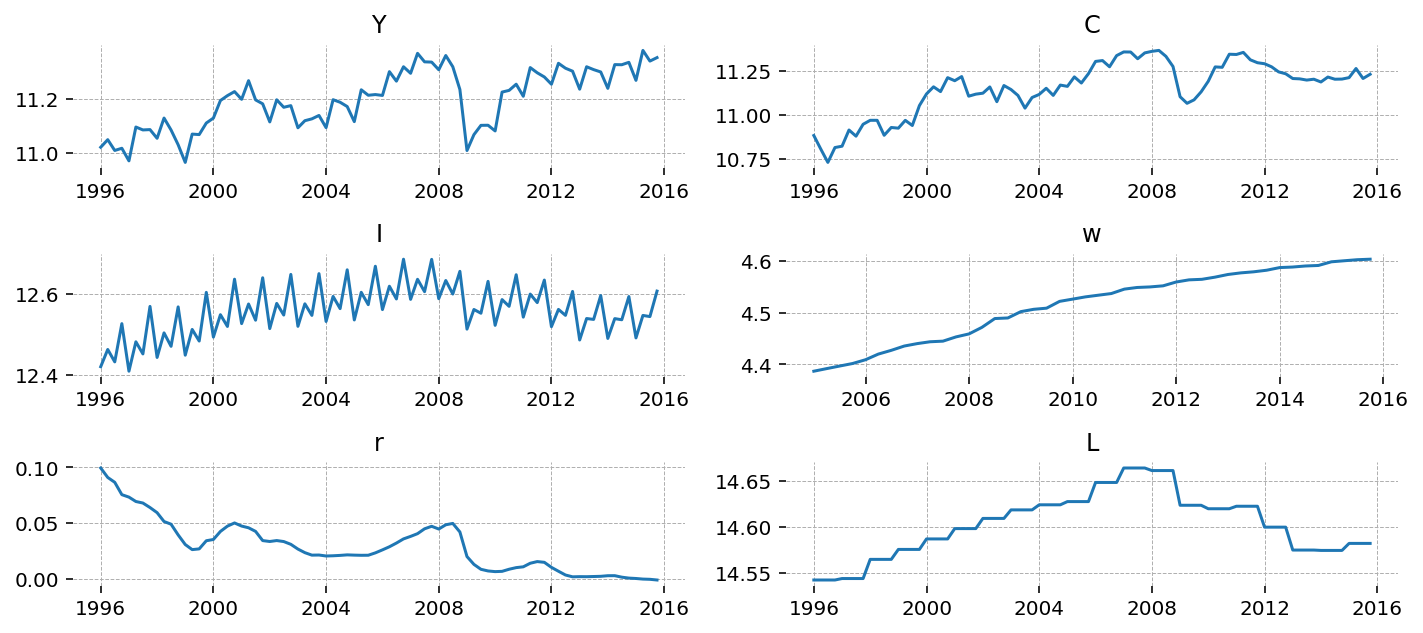

In [13]:
plot_df(train)

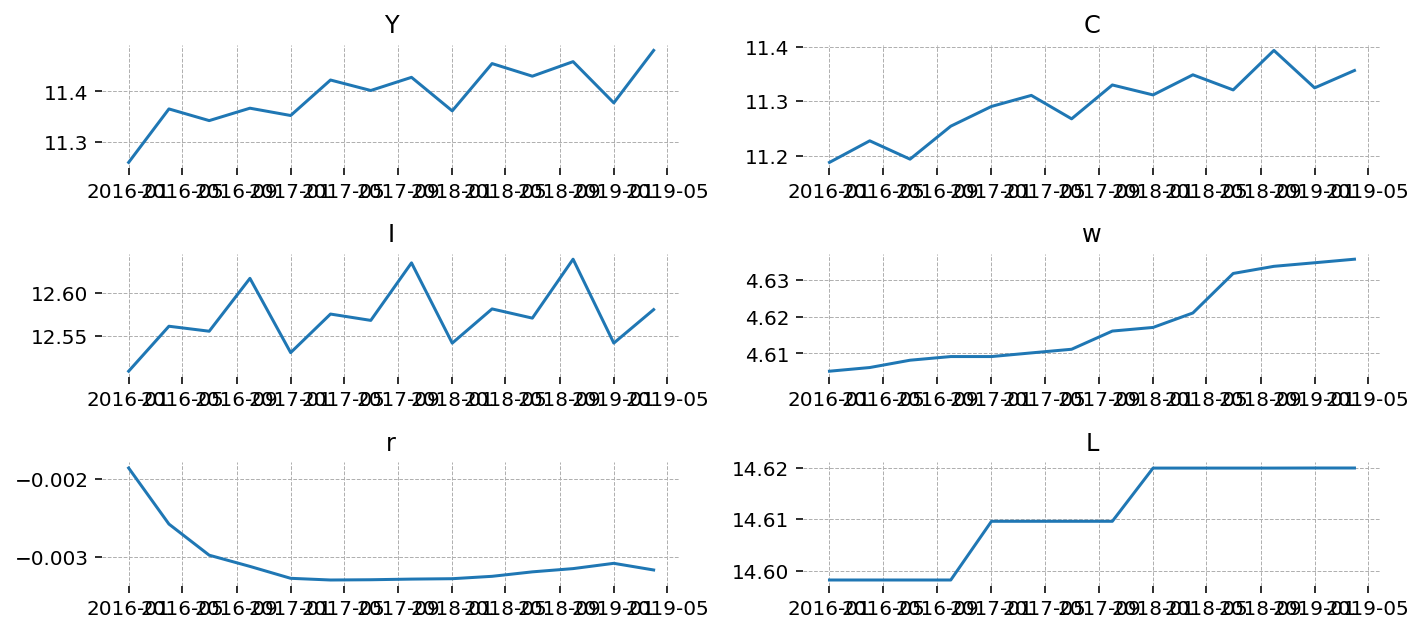

In [14]:
plot_df(test)

### Detrend the Data <a class="anchor" id="section_3_3"></a>

We apply a polynomial detrender to the data. Depending on the variables we have used polynomials of degree 1 or 2. The reason is that not every variables (look at the plots before) follow a clear linear trend. 
Interest rate is left out because it is set by CB thus no 'trend' in time series terms.

In [15]:
poly_order = {"Y": 1, 
              "C": 2, 
              "I": 2,
              "w": 1,
              "L": 2}
mask = train.copy()
for col in [item for item in glob_cols if item != 'r']:
    _ = train[col].dropna().copy()
    func_form = np.polyfit(list(range(0, len(_))), _, poly_order[col])
    
    train[col] = poly_detrend(train[col], poly_order=poly_order[col], skipna=True)   
    test[col] = poly_detrend(test[col], poly_order=poly_order[col], skipna=True)   
    mask[col] = poly_detrend(train[col], poly_order=poly_order[col], skipna=True, return_pred=True)
       
#     test[col] = np.polyval(func_form, test[col])

In [16]:
# interest rate is stationary at 10% level
ADF_test_summary(train['r'])

                                                      r                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.103         -3.340        0.060          1    -4.080      -3.468     -3.161
	Constant             0.005          2.620        0.011
	Trend               -0.000         -2.375        0.020
Constant Only               -0.043         -2.368        0.151          1    -3.517      -2.899     -2.587
	Constant             0.001          1.135        0.260
No Constant                 -0.027         -2.361        0.018          1    -2.595      -1.945     -1.614


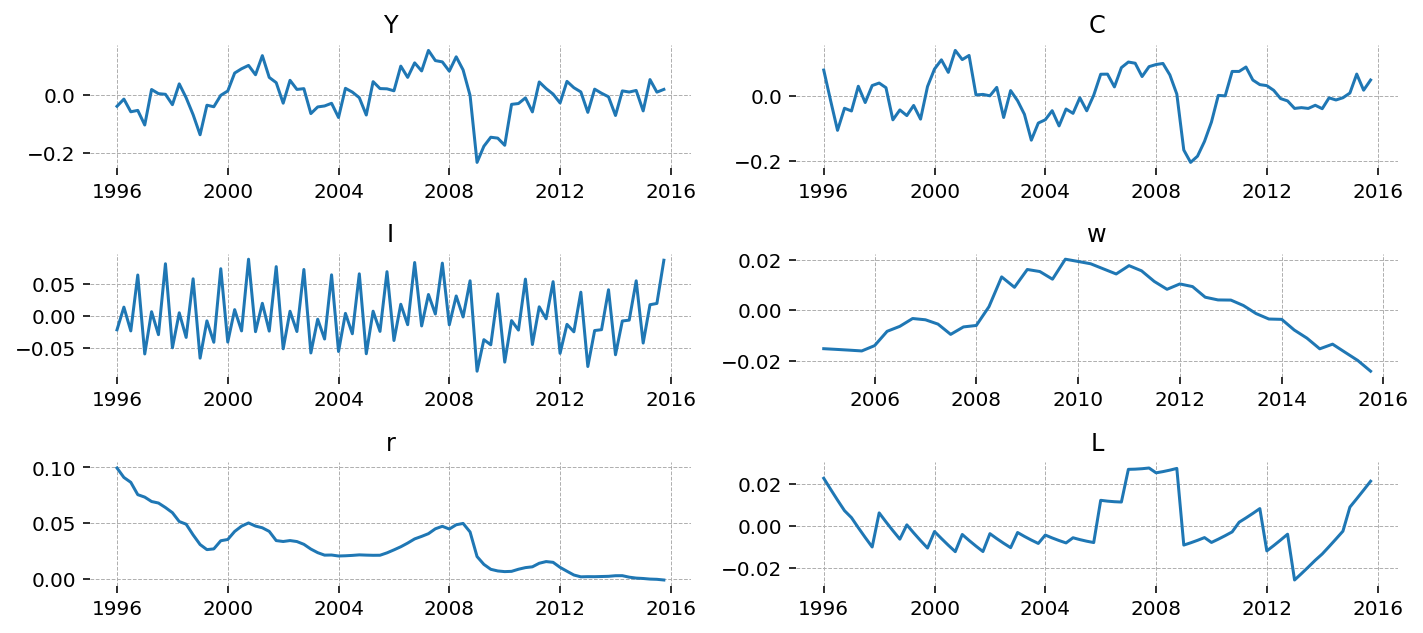

In [17]:
plot_df(train)

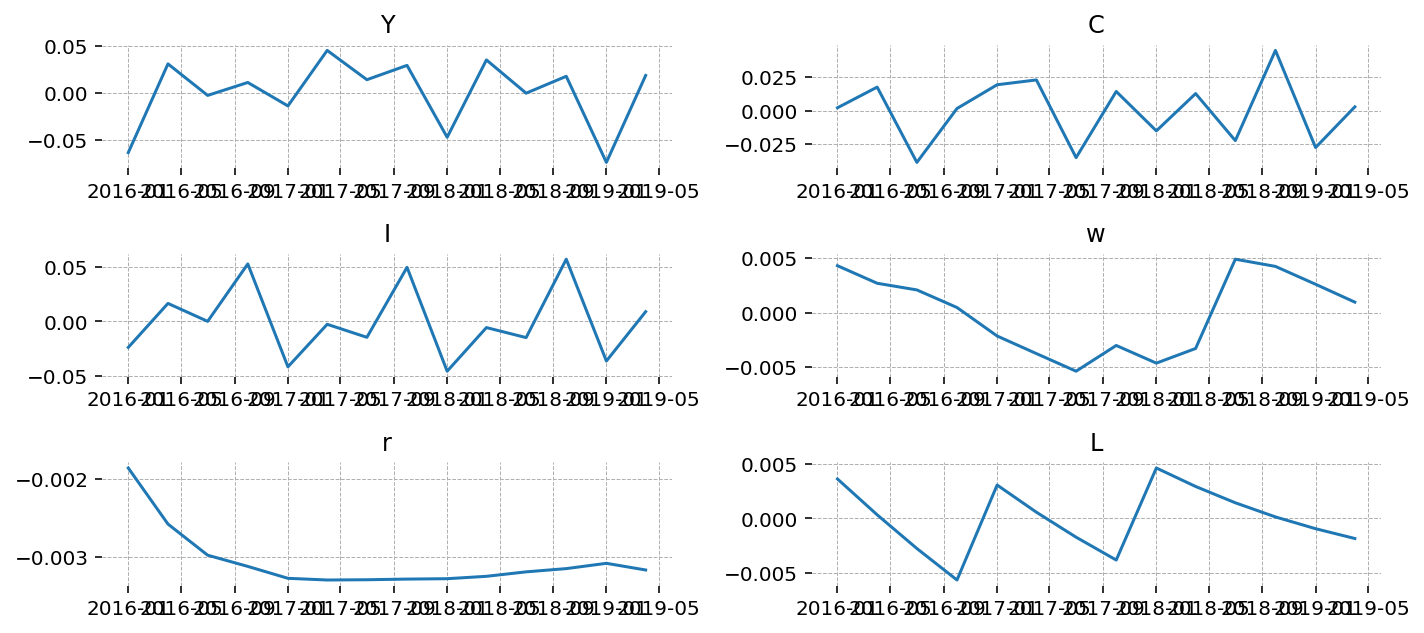

In [18]:
plot_df(test)

### Deseasonalize the Data <a class="anchor" id="section_3_2"></a>

In [19]:
_ = get_max_seasonal(train, ) #train.drop("w", axis=1))

Y: strongest effect at 2 lags
I: strongest effect at 16 lags
r: strongest effect at 2 lags
C: strongest effect at 3 lags
w: strongest effect at 2 lags
L: strongest effect at 2 lags


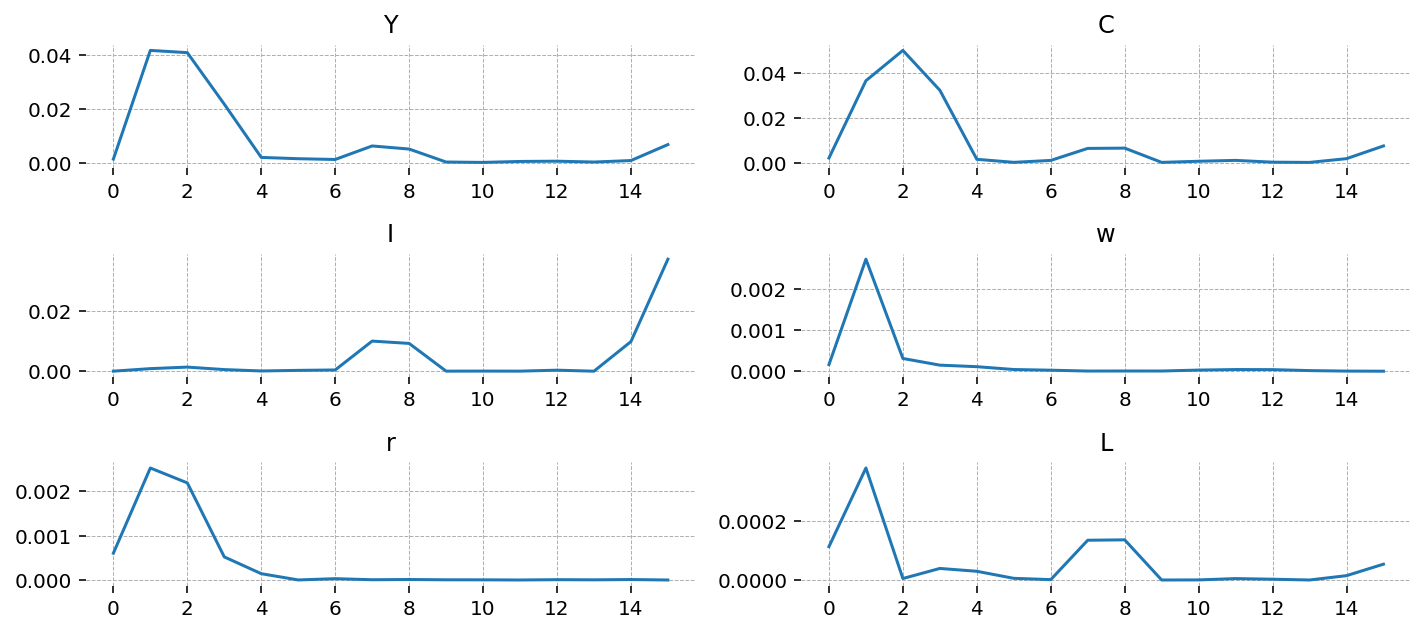

In [20]:
plot_df(_)

In [21]:
_train = train.copy()
_test = test.copy()

#### OLS method <a class="anchor" id="subsection_1"></a>

In [22]:
for col in glob_cols: # r is also seasonal as real r might fluctuate with inflation (which it self is seasonal) while CB holds i constant
    model = OLS_dummie_deseasonal()
    _train[col] = model.get_trend(train[col])
    _test[col] = model.predict(test[col])

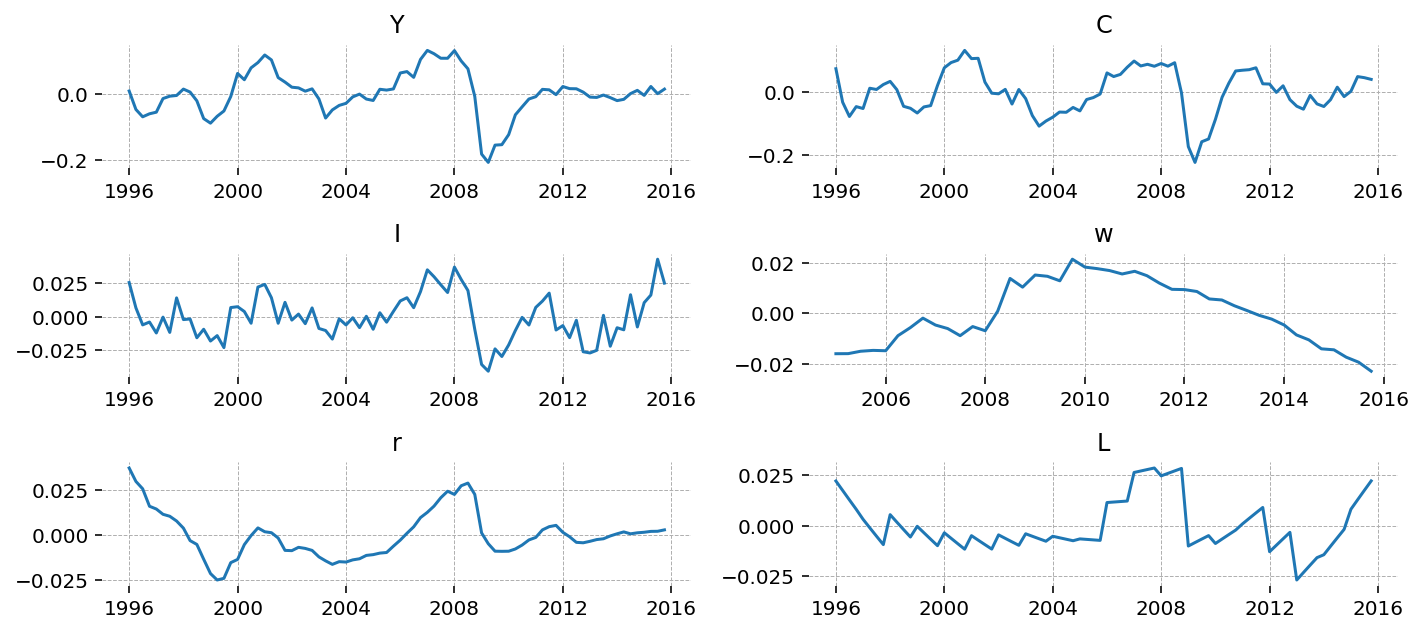

In [23]:
plot_df(_train)

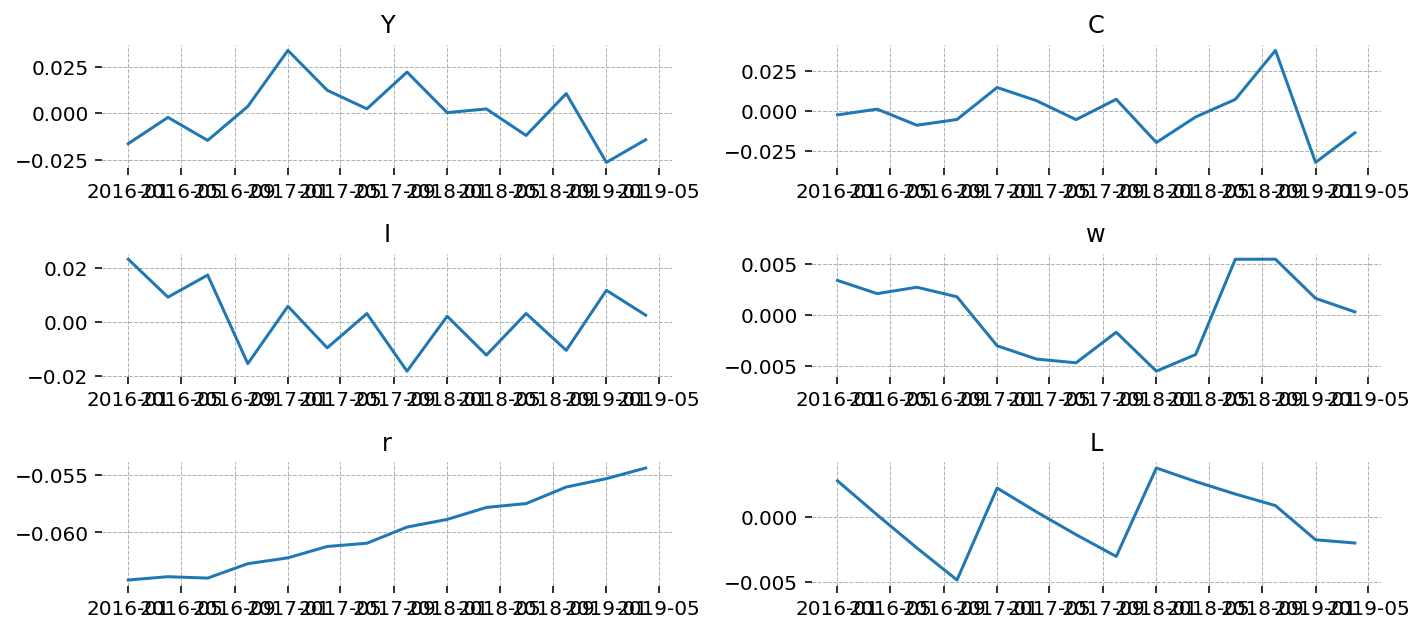

In [24]:
plot_df(_test)

In [25]:
### check stationarity
ADF_test_summary(_train.drop('w', axis=1), missing='drop')

                                                      Y                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.244         -4.196        0.005          3    -4.083      -3.470     -3.162
	Constant             0.003          0.438        0.663
	Trend               -0.000         -0.341        0.734
Constant Only               -0.180         -3.550        0.007          1    -3.517      -2.899     -2.587
	Constant             0.001          0.237        0.813
No Constant                 -0.180         -3.573        0.000          1    -2.595      -1.945     -1.614
                                                      I                                                       
Specification               Coeff          Statistic     P-value      La

#### HP Filter <a class="anchor" id="subsection_2"></a>

In [26]:
for col in glob_cols:
    _train[col] = get_seasonal_hp(train[col], lamb=6.25, skipna=True)
    _test[col] = get_seasonal_hp(test[col], lamb=6.25, skipna=True)

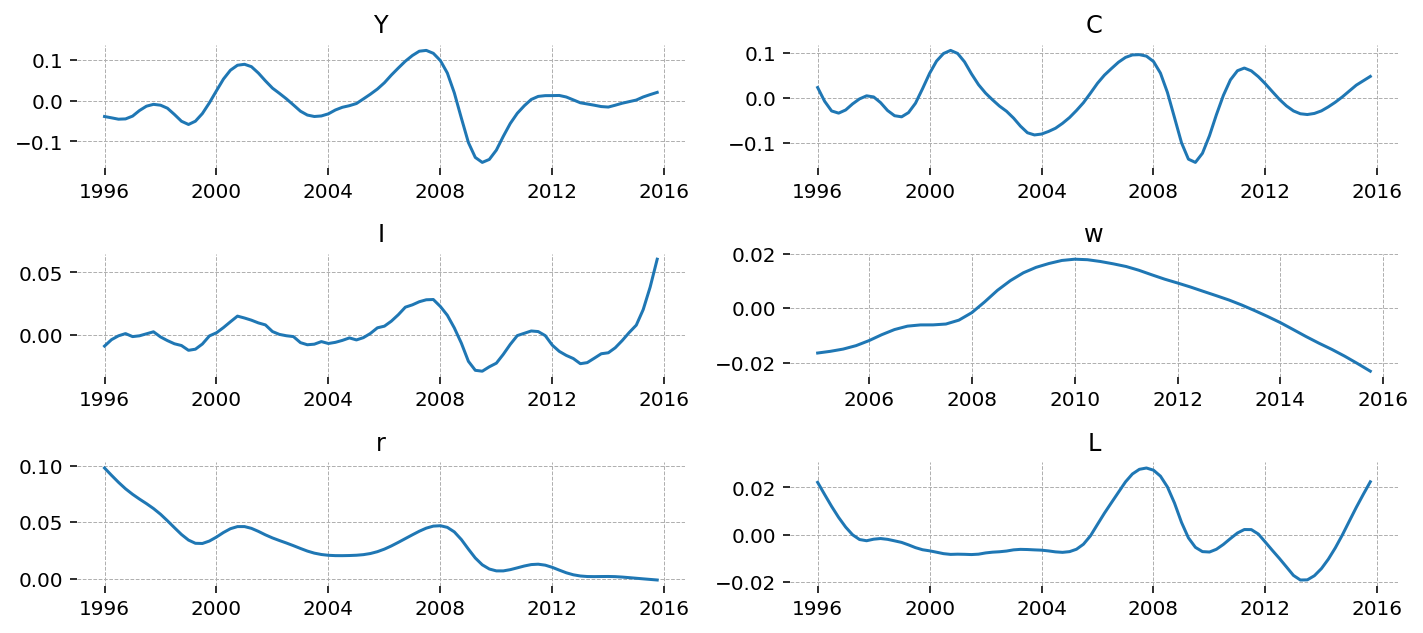

In [27]:
plot_df(_train)

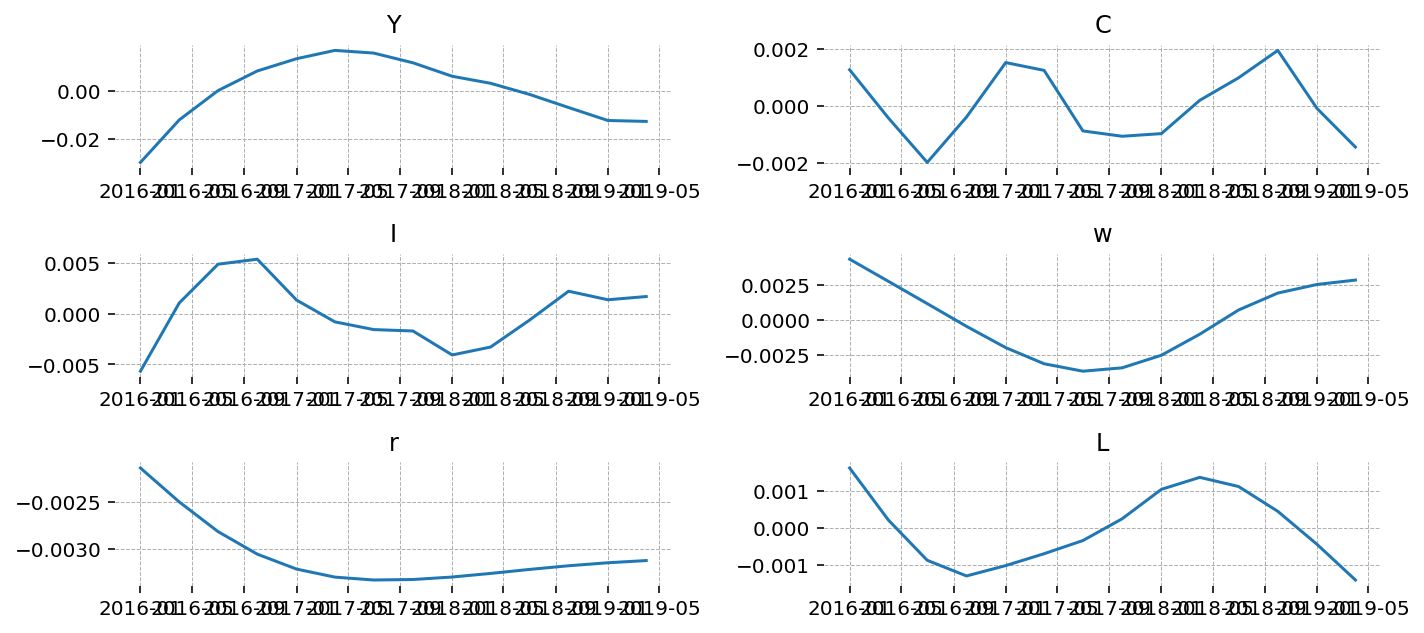

In [28]:
plot_df(_test)

In [29]:
### check stationarity
# 'no constant' is the p-val of interest
ADF_test_summary(_train.drop('w', axis=1), missing='drop')

                                                      Y                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.034         -3.029        0.124          8    -4.092      -3.474     -3.164
	Constant             0.001          0.818        0.416
	Trend               -0.000         -0.605        0.548
Constant Only               -0.033         -2.989        0.036          8    -3.526      -2.903     -2.589
	Constant             0.000          0.598        0.552
No Constant                 -0.032         -2.971        0.003          8    -2.598      -1.945     -1.614
                                                      I                                                       
Specification               Coeff          Statistic     P-value      La

We will use the HP filter in the next sections. The OLS regression, a more naive approach produces similar results, but the HP filter smoothes better the data and its the most common tools in that kind of applications.

In [30]:
train = _train.copy()
test = _test.copy()

# RBC Model <a class="anchor" id="chapter3"></a>

In [31]:
rbc = ge.gEconModel(os.path.join(DATA_DIR, 'rbc_basic.gnc'))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\leona\\Documents\\GitHub\\macro_rbc\\data\\rbc_basic.gnc'

## Model Equations <a class="anchor" id="section_3_1"></a>

In [32]:
for equation in rbc.system_equations:
    display(equation)

-C_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 - lambda_t+1*(delta - 1)) - lambda_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

## Find Steady State, Solve the Model <a class="anchor" id="section_3_2"></a>

In [33]:
rbc.steady_state()
rbc.solve_model()

Steady state found! Sum of squared residuals is 1.47501368398038e-19
Solution found, sum of squared residuals:  4.0781870427091863e-29
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [34]:
rbc.print_steady_state()

A_ss               1.000
C_ss               6.790
I_ss               1.018
K_ss             101.771
L_ss               3.138
Y_ss               7.808
lambda_ss          0.987
r_ss               0.020
w_ss               1.836


## Check Blanchard Kahn Conditions <a class="anchor" id="section_3_3"></a>

As we know from theory the Blanchard condition are important because they let us understand if the model has a unique solution through the steady state.

In [35]:
rbc.check_bk_condition()

Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.


Modulus          Real  Imaginary
0  1.381675e-19  1.381675e-19        0.0
1  1.654782e-17  1.654782e-17        0.0
2  2.750983e-17  2.750983e-17        0.0
3  5.917828e-17  5.917828e-17        0.0
4  7.395453e-01  7.395453e-01        0.0
5  9.405000e-01  9.405000e-01        0.0
6  1.365841e+00  1.365841e+00        0.0
7  4.696784e+06  4.696784e+06        0.0

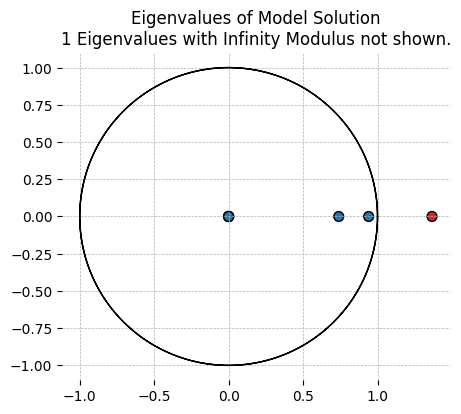

In [36]:
gp.plot_eigenvalues(rbc);

In [37]:
#Run IRFs with our starting parameters to compare with the estimated parameters at the end.
base_irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

As we can see the output the number of unstable variables is the same as the number of control variable as a consequence the system has a unique solution.

# Maximum Likelihood Estimation <a class="anchor" id="chapter4"></a>

In [38]:
# assign date freq
train = train.asfreq("QS")
train.head()

Y         I         r         C   w         L
TIME                                                            
1996-01-01 -0.038572 -0.008759  0.097885  0.022497 NaN  0.022162
1996-04-01 -0.041820 -0.003640  0.091451 -0.007947 NaN  0.017030
1996-07-01 -0.045196 -0.000573  0.085275 -0.029443 NaN  0.012016
1996-10-01 -0.044496  0.001199  0.079549 -0.034302 NaN  0.007327
1997-01-01 -0.037604 -0.001199  0.074687 -0.027251 NaN  0.003230

## Simple model <a class="anchor" id="section_4_1"></a>

In [1]:
MLEModel = ge.compile_to_statsmodels(rbc)

NameError: name 'ge' is not defined

In [40]:
calibrated_params = {'beta':0.9998, 'alpha':0.262, 'sigma_L':0.52,'sigma_C': 0.0068, 'delta':0.01, 'rho_A': 0.9405}
rbc.free_param_dict.update(calibrated_params)

In [41]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_A':0.85
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_A':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
#     'Y':0.01,
#     'C':0.02,
#     'L':0.05,
#     'I':0.02,
#     'r':0.03,
#     'w':0.1
                    }

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
#     'sigma_C': IntervalTransformer(low=1.05, high=10.0, slope=1),
#     'sigma_L': IntervalTransformer(low=1.05, high=10.0, slope=1),
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
    'alpha':IntervalTransformer(low=0.0001, high=0.99, slope=1)
}

mle_mod = MLEModel(train[["Y"]],
                   param_start_dict = param_start_dict,
                   shock_start_dict = shock_start_dict,
                   noise_start_dict = noise_start_dict,
                   param_transforms = param_transforms,
                   shock_transforms=None, 
                   noise_transforms=None, 
                   initialization='stationary')

In [42]:
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}), maxiter=100)

basinhopping step 0: f -2.35714
basinhopping step 1: f -2.38242 trial_f -2.38242 accepted 1  lowest_f -2.38242
found new global minimum on step 1 with function value -2.38242
basinhopping step 2: f -2.40452 trial_f -2.40452 accepted 1  lowest_f -2.40452
found new global minimum on step 2 with function value -2.40452
basinhopping step 3: f -2.40729 trial_f -2.40729 accepted 1  lowest_f -2.40729
found new global minimum on step 3 with function value -2.40729
basinhopping step 4: f -2.37269 trial_f -2.37269 accepted 1  lowest_f -2.40729
basinhopping step 5: f -2.3689 trial_f -2.3689 accepted 1  lowest_f -2.40729
basinhopping step 6: f -2.3744 trial_f -2.3744 accepted 1  lowest_f -2.40729
basinhopping step 7: f -2.38633 trial_f -2.38633 accepted 1  lowest_f -2.40729
basinhopping step 8: f -2.38633 trial_f -2.29054 accepted 0  lowest_f -2.40729
basinhopping step 9: f -2.38207 trial_f -2.38207 accepted 1  lowest_f -2.40729
basinhopping step 10: f -2.3879 trial_f -2.3879 accepted 1  lowest_f 

basinhopping step 63: f -2.12451 trial_f -2.12451 accepted 1  lowest_f -2.4104
basinhopping step 64: f -2.11601 trial_f -2.11601 accepted 1  lowest_f -2.4104
basinhopping step 65: f -1.98761 trial_f -1.98761 accepted 1  lowest_f -2.4104
basinhopping step 66: f -1.90484 trial_f -1.90484 accepted 1  lowest_f -2.4104
basinhopping step 67: f -2.10645 trial_f -2.10645 accepted 1  lowest_f -2.4104
basinhopping step 68: f -1.55361 trial_f -1.55361 accepted 1  lowest_f -2.4104
basinhopping step 69: f -2.06005 trial_f -2.06005 accepted 1  lowest_f -2.4104
basinhopping step 70: f -2.10735 trial_f -2.10735 accepted 1  lowest_f -2.4104
basinhopping step 71: f -2.10149 trial_f -2.10149 accepted 1  lowest_f -2.4104
basinhopping step 72: f -2.07252 trial_f -2.07252 accepted 1  lowest_f -2.4104
basinhopping step 73: f -1.99372 trial_f -1.99372 accepted 1  lowest_f -2.4104
basinhopping step 74: f -2.08958 trial_f -2.08958 accepted 1  lowest_f -2.4104
basinhopping step 75: f -2.07735 trial_f -2.07735 ac

In [43]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                   80
Model:                      DSGEModel   Log Likelihood                  52.625
Date:                Wed, 07 Dec 2022   AIC                           -101.251
Time:                        21:00:39   BIC                            -96.487
Sample:                    01-01-1996   HQIC                           -99.341
                         - 10-01-2015                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.8676      0.197      4.413      0.000       0.482       1.253
sigma2.epsilon_A     0.0105      0.002      4.257      0.000       0.006       0.015
===================================================================================
Ljung-Box (L1) (Q):                  67.67   Jarque-Bera (JB):                40.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.18
Prob(H) (two-sided):                  0.69   Kurtosis:                         5.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

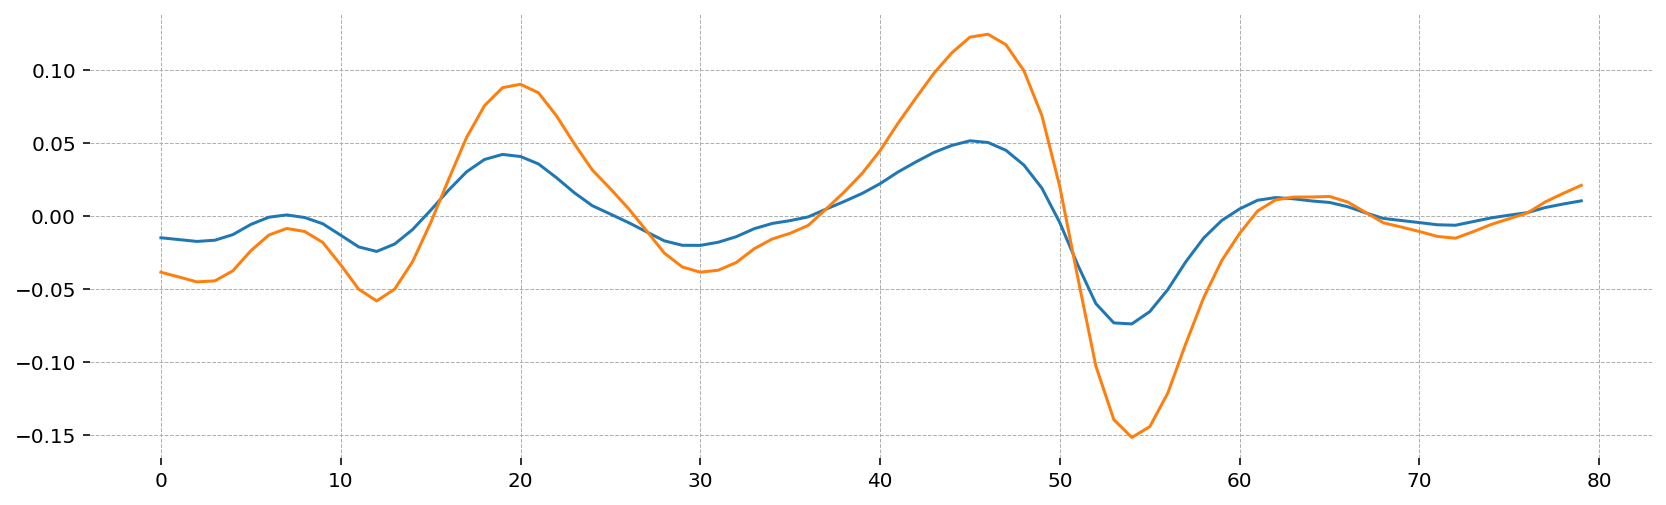

In [44]:
# without any observation noise the 'filter' output should equal the data, why not the case ??
plt.plot(mle_res.filtered_state[0])
plt.plot(train.Y.values)

### MLE Kalman Filter Prediction Plots <a class="anchor" id="subsection_4_1"></a>

Predictions

The model does not pick-up on much variation in the data. Confidence intervals are rather broad and predicted variations seem random. In magnitude deviations go far beyond the actual data, suggesting that the model has not capture the variance correctly.

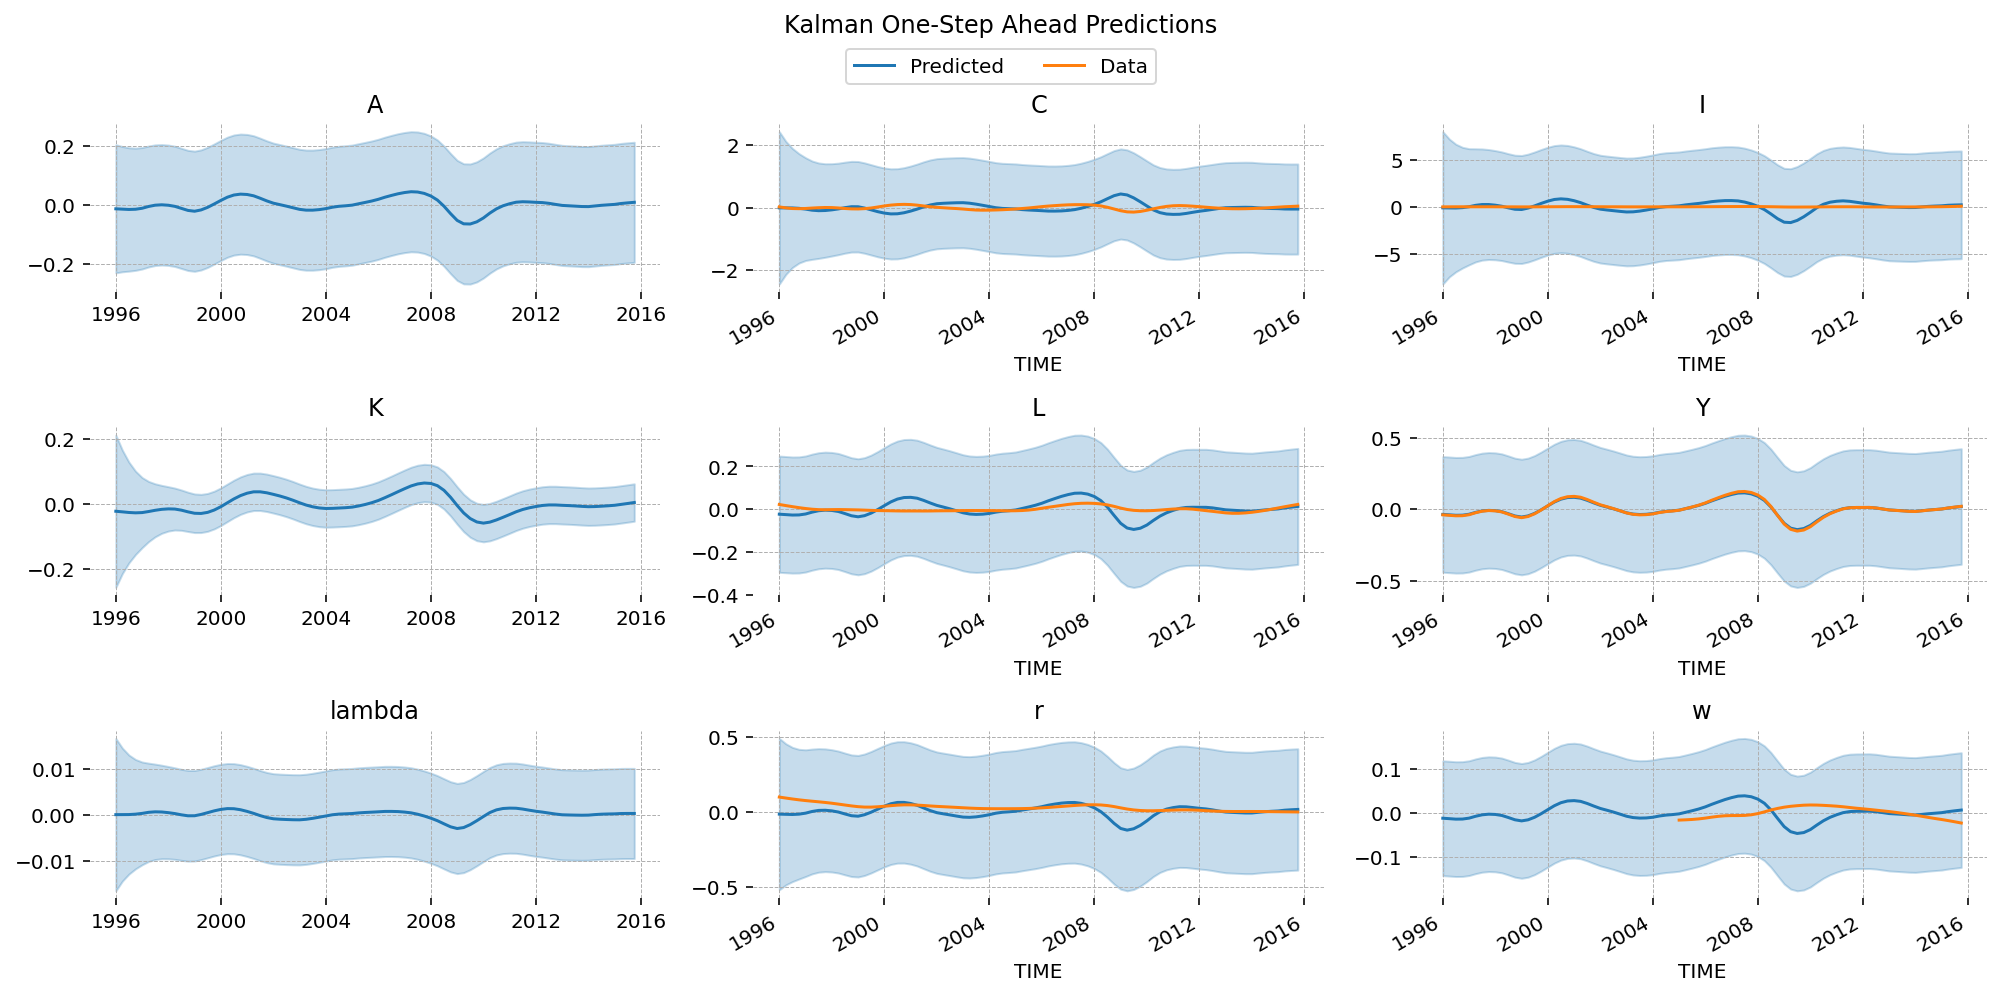

In [45]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

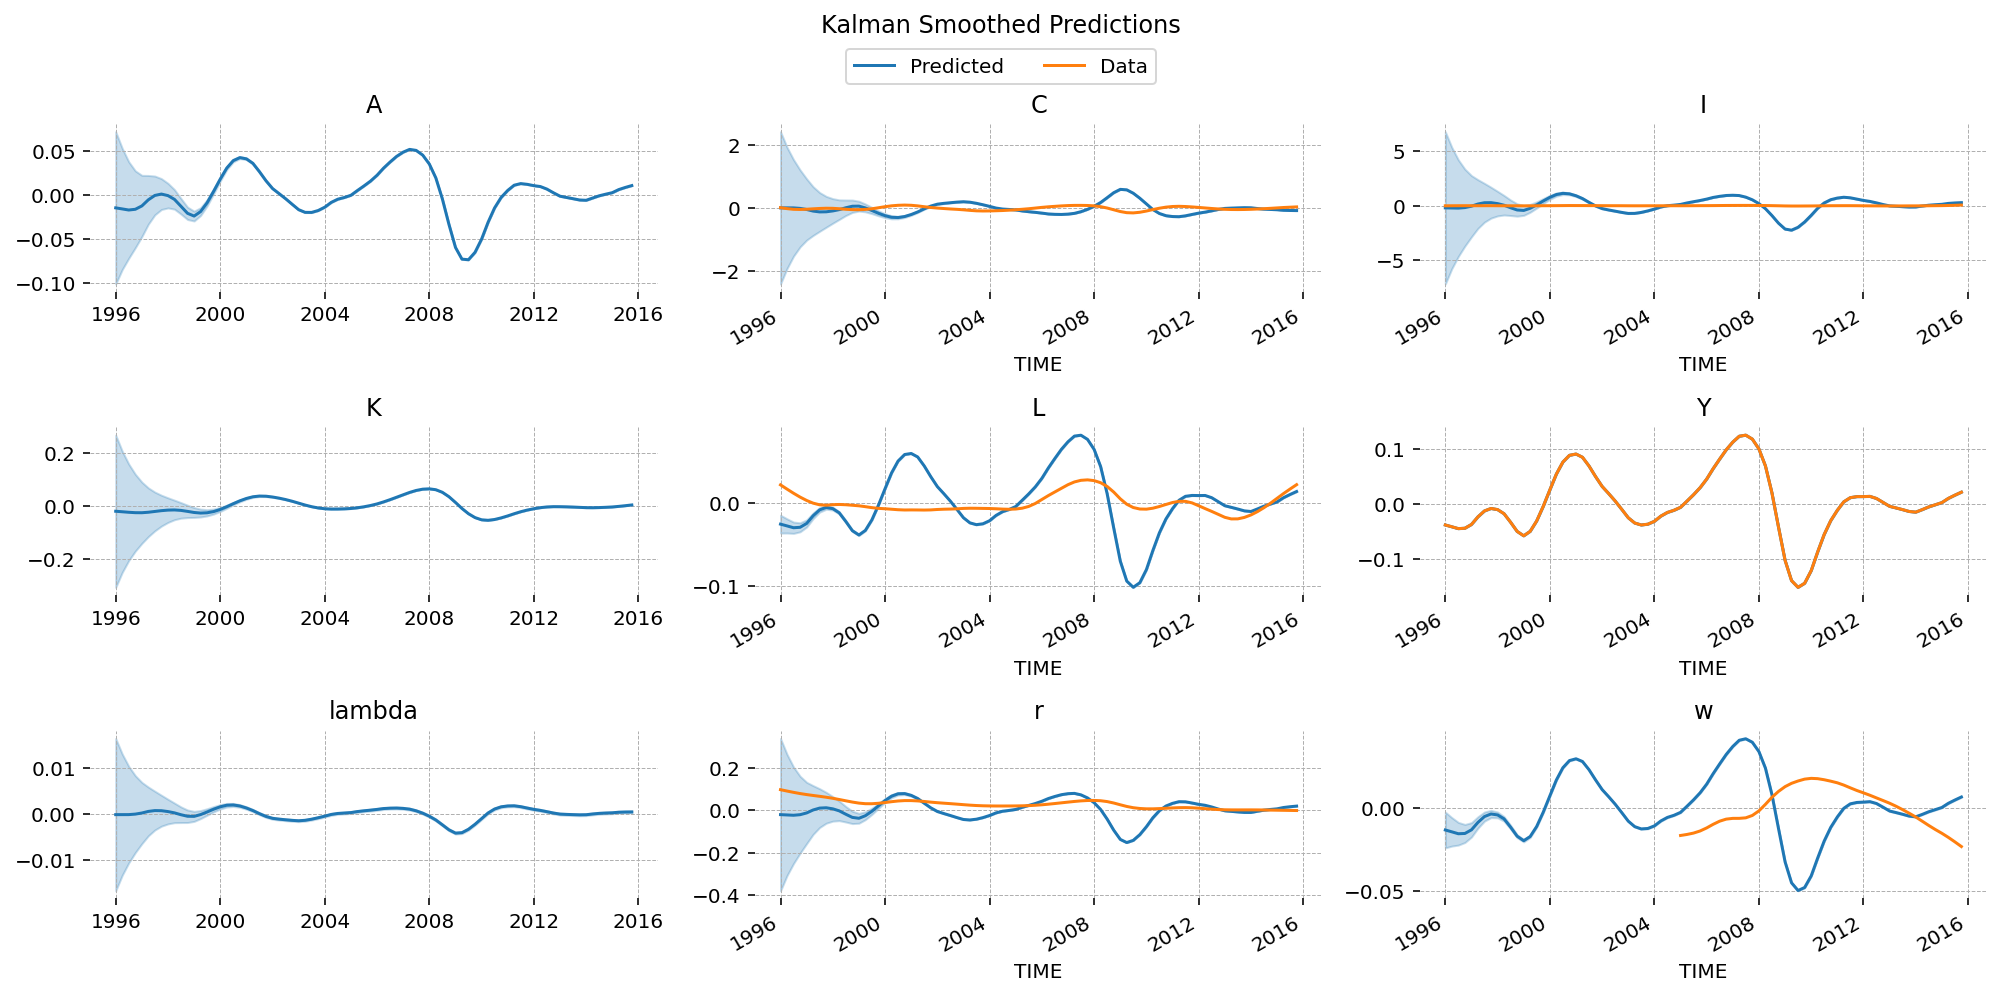

In [46]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="subsection_4_2"></a>

In [47]:
mle_forecast = mle_res.get_forecast(steps=test_size)

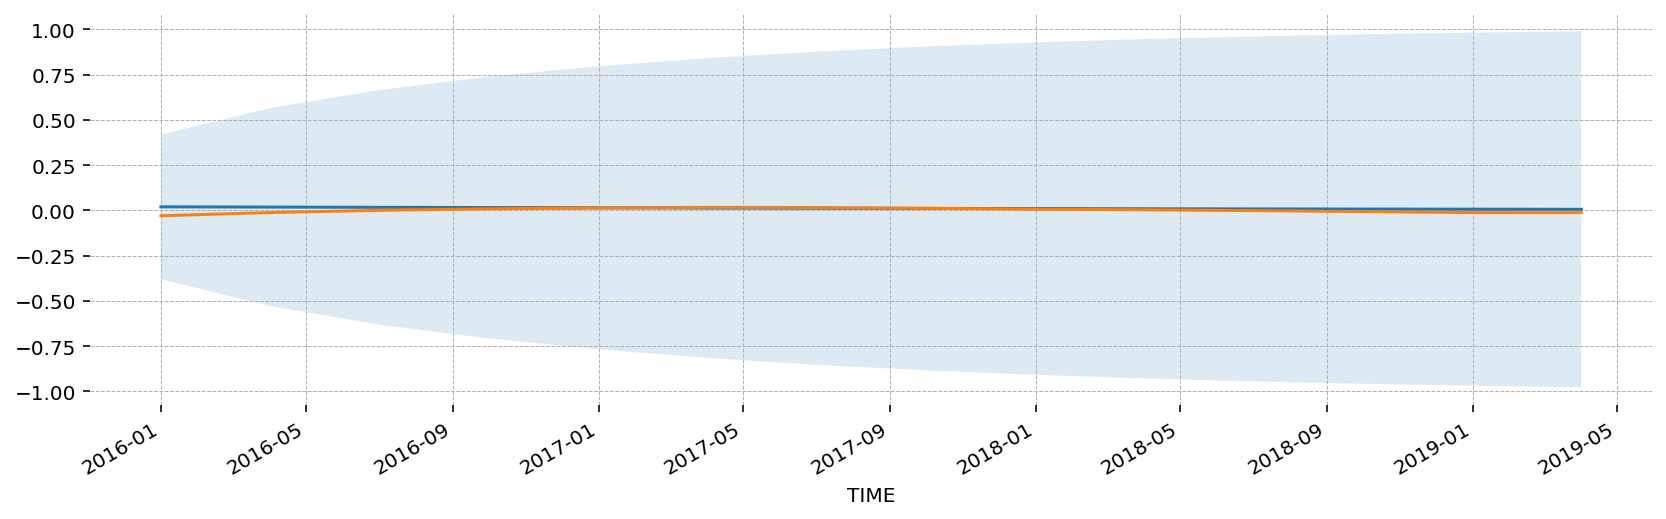

In [48]:
mu = mle_forecast.predicted_mean

# var_pred_mean is the variance, but the 95% CI will be +/- 1.96 * std, so we have to take square root.
sigma = 1.96 * np.sqrt(mle_forecast.var_pred_mean)

fig, ax = plt.subplots()
ax.plot(mu)
ax.fill_between(mu.index, mu - sigma, mu + sigma, alpha=0.15)
test.Y.plot(ax=ax)
plt.show()

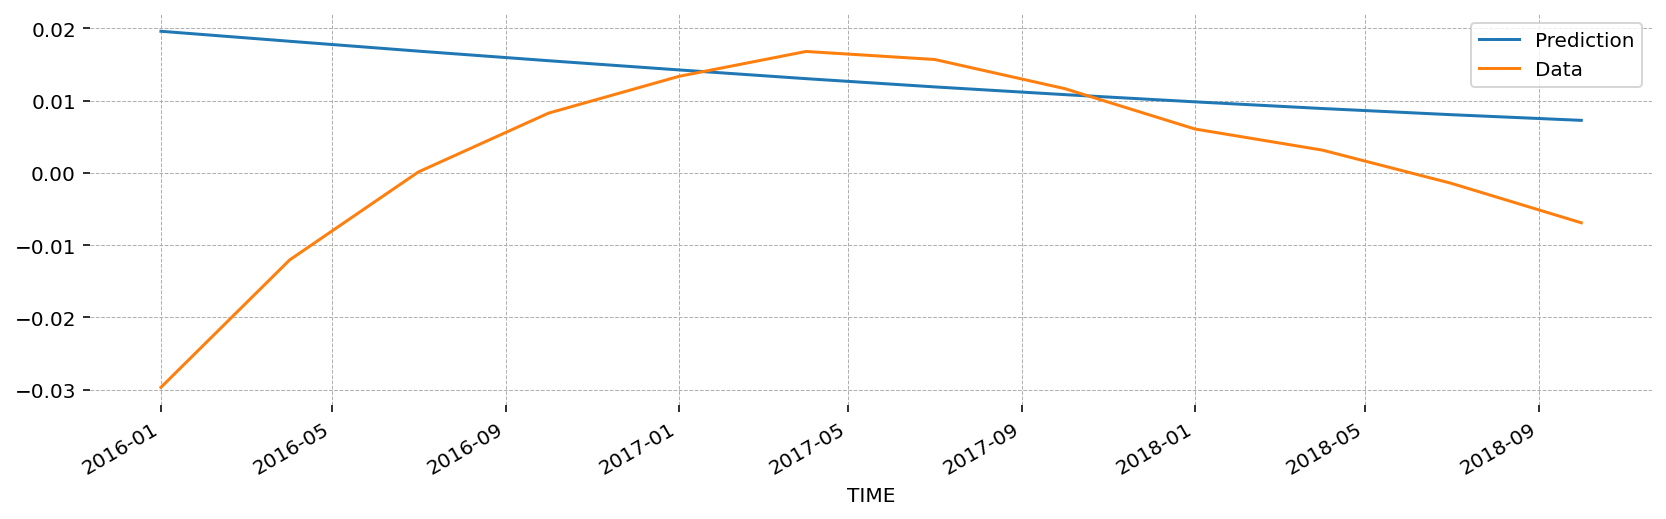

In [49]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

Our model has not correctly captured the notion of an overbooming economy, that evenutally declines. This could be an interpretation of the down-turn in 2017, which has been preceeded by years of recovery and subsquent boom of post 08.

## A noisy model <a class="anchor" id="section_4_2"></a>

In [50]:
MLEModel = ge.compile_to_statsmodels(rbc)

In [51]:
calibrated_params = {'beta':0.9998, 'alpha':0.262, 'sigma_L':0.52,'sigma_C': 0.0068, 'delta':0.01, 'rho_A': 0.9405}
rbc.free_param_dict.update(calibrated_params)

In [52]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_A':0.85
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_A':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
    'Y':0.01,
                    }

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
#     'alpha':IntervalTransformer(low=0.0001, high=0.99, slope=1)
}

mle_mod = MLEModel(train[["Y"]],
                   param_start_dict = param_start_dict,
                   shock_start_dict = shock_start_dict,
                   noise_start_dict = noise_start_dict,
                   param_transforms = param_transforms,
                   shock_transforms=None, 
                   noise_transforms=None, 
                   initialization='stationary')

In [53]:
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}), maxiter=100)

basinhopping step 0: f -2.36222
basinhopping step 1: f -2.37737 trial_f -2.37737 accepted 1  lowest_f -2.37737
found new global minimum on step 1 with function value -2.37737
basinhopping step 2: f -2.41238 trial_f -2.41238 accepted 1  lowest_f -2.41238
found new global minimum on step 2 with function value -2.41238
basinhopping step 3: f -2.4105 trial_f -2.4105 accepted 1  lowest_f -2.41238
basinhopping step 4: f -2.4105 trial_f -1.83509 accepted 0  lowest_f -2.41238
basinhopping step 5: f -2.40856 trial_f -2.40856 accepted 1  lowest_f -2.41238
basinhopping step 6: f -2.41288 trial_f -2.41288 accepted 1  lowest_f -2.41288
found new global minimum on step 6 with function value -2.41288
basinhopping step 7: f -2.07884 trial_f -2.07884 accepted 1  lowest_f -2.41288
basinhopping step 8: f -2.40348 trial_f -2.40348 accepted 1  lowest_f -2.41288
basinhopping step 9: f -2.20955 trial_f -2.20955 accepted 1  lowest_f -2.41288
basinhopping step 10: f -2.2186 trial_f -2.2186 accepted 1  lowest_f

basinhopping step 63: f -1.85492 trial_f -1.85492 accepted 1  lowest_f -2.43094
basinhopping step 64: f -2.14359 trial_f -2.14359 accepted 1  lowest_f -2.43094
basinhopping step 65: f -2.14359 trial_f -1.29548 accepted 0  lowest_f -2.43094
basinhopping step 66: f -2.11838 trial_f -2.11838 accepted 1  lowest_f -2.43094
basinhopping step 67: f -2.18043 trial_f -2.18043 accepted 1  lowest_f -2.43094
basinhopping step 68: f -1.91273 trial_f -1.91273 accepted 1  lowest_f -2.43094
basinhopping step 69: f -2.13912 trial_f -2.13912 accepted 1  lowest_f -2.43094
basinhopping step 70: f -2.13912 trial_f -1.43169 accepted 0  lowest_f -2.43094
basinhopping step 71: f -2.21565 trial_f -2.21565 accepted 1  lowest_f -2.43094
basinhopping step 72: f -2.2143 trial_f -2.2143 accepted 1  lowest_f -2.43094
basinhopping step 73: f -2.09106 trial_f -2.09106 accepted 1  lowest_f -2.43094
basinhopping step 74: f -2.14211 trial_f -2.14211 accepted 1  lowest_f -2.43094
basinhopping step 75: f -1.63825 trial_f -

In [61]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                   80
Model:                      DSGEModel   Log Likelihood                  50.457
Date:                Wed, 07 Dec 2022   AIC                            -94.914
Time:                        21:05:36   BIC                            -87.768
Sample:                    01-01-1996   HQIC                           -92.049
                         - 10-01-2015                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9229      1.068      0.864      0.388      -1.171       3.017
sigma2.epsilon_A     0.0108      0.213      0.050      0.960      -0.407       0.429
sigma2.Y           6.94e-05      0.416      0.000      1.000      -0.816       0.816
===================================================================================
Ljung-Box (L1) (Q):                  67.21   Jarque-Bera (JB):                36.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -1.11
Prob(H) (two-sided):                  0.80   Kurtosis:                         5.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

Estimated variance of Y is very close to zero, the data seems trustworthy

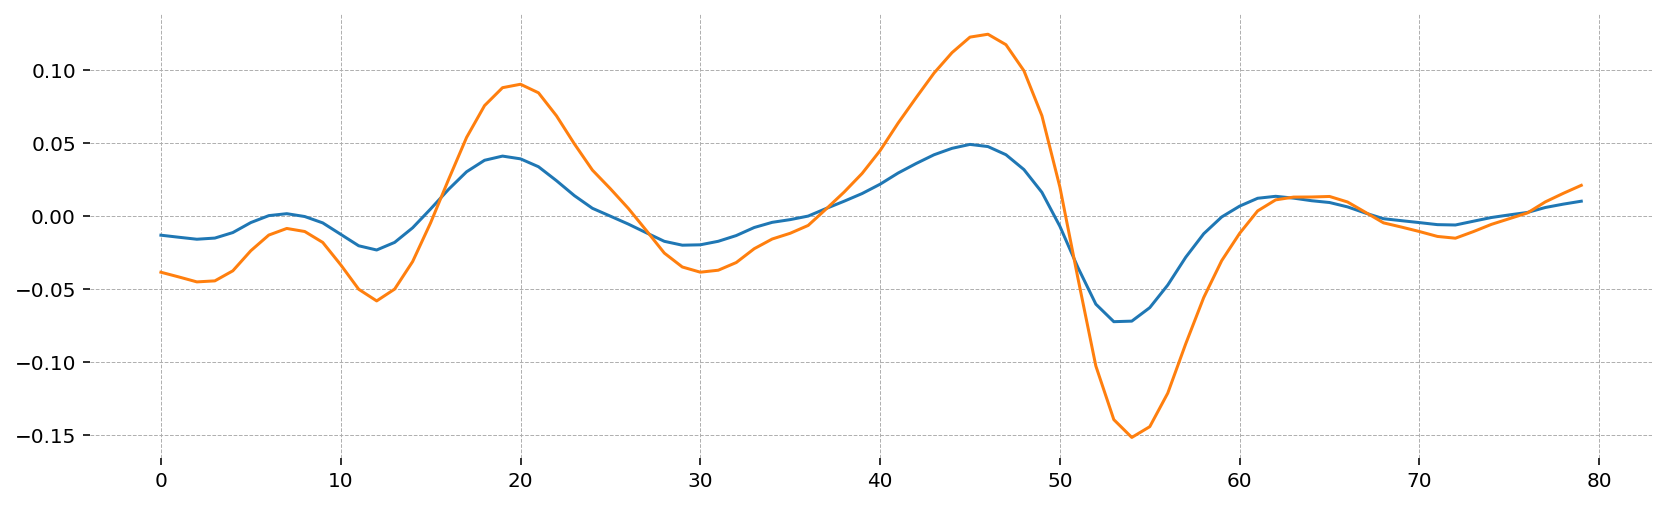

In [62]:
plt.plot(mle_res.filtered_state[0])
plt.plot(train.Y.values)

### MLE Kalman Filter Prediction Plots <a class="anchor" id="section_4_3"></a>

Predictions

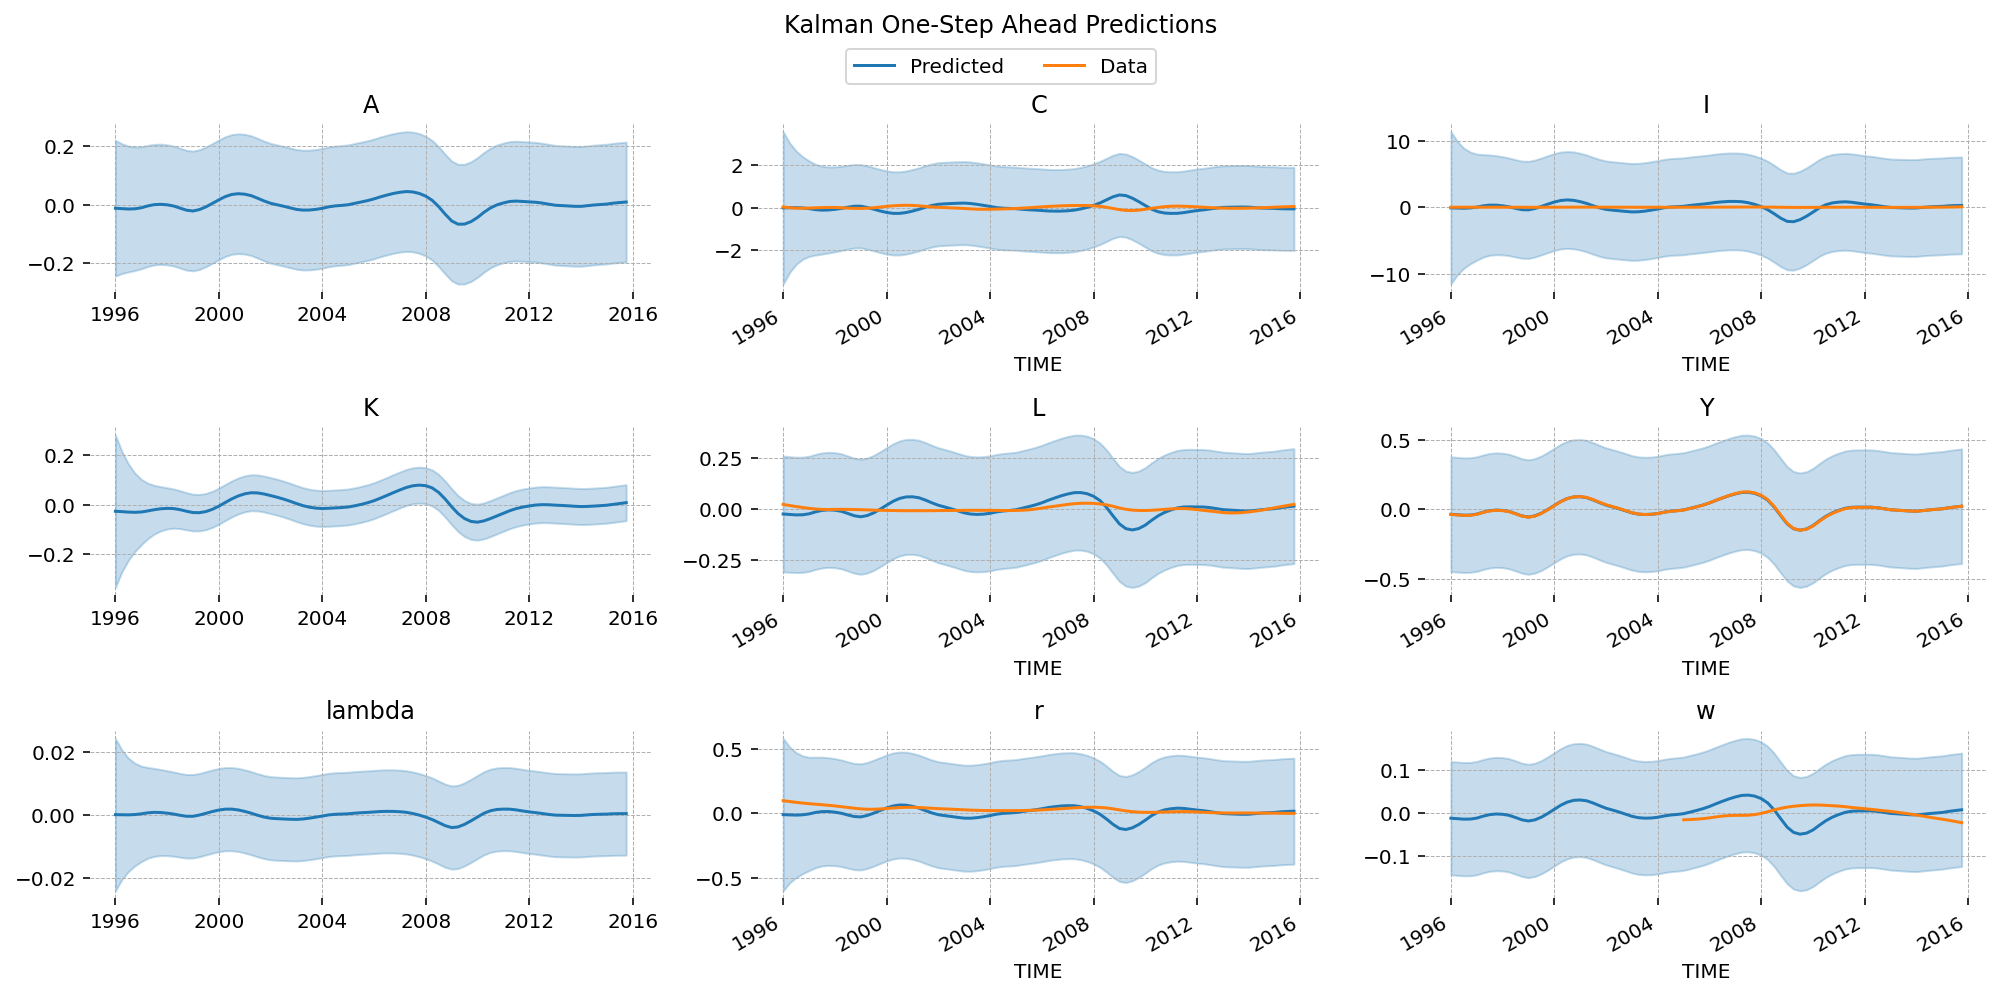

In [63]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

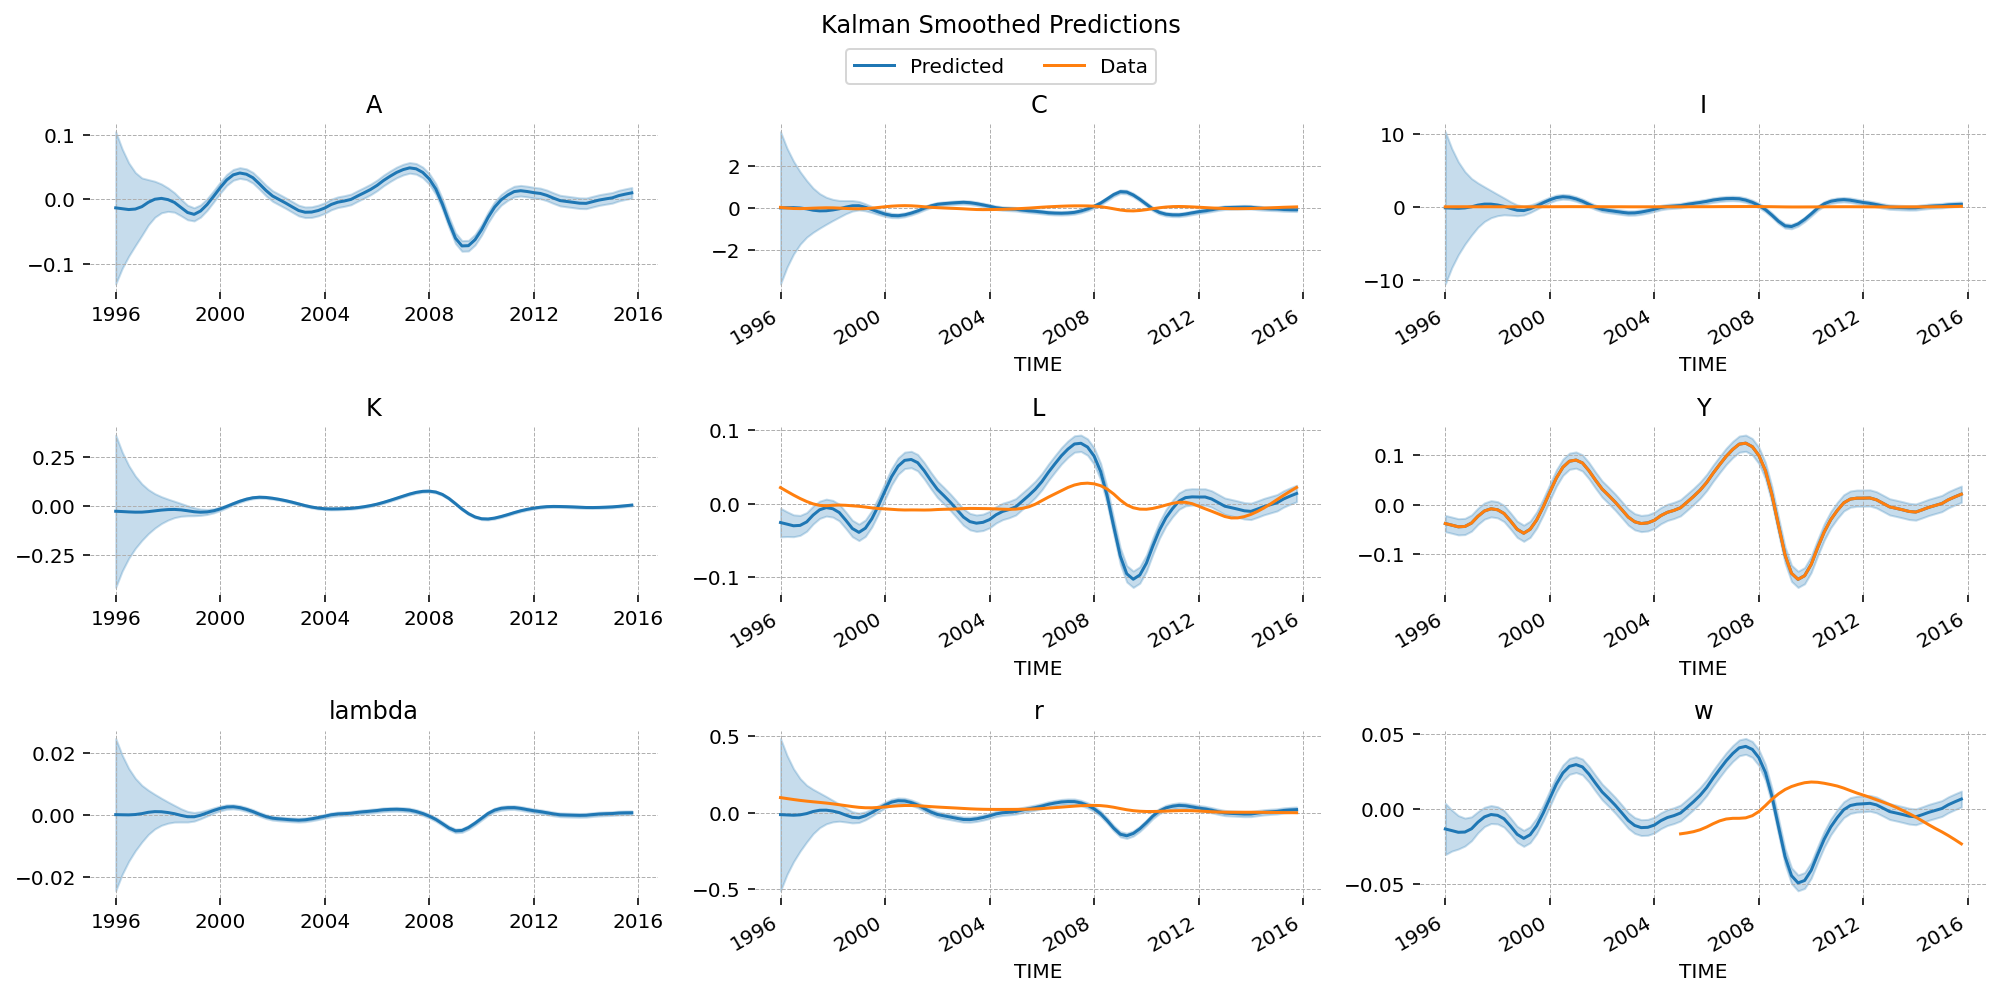

In [64]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="section_4_4"></a>

In [65]:
mle_forecast = mle_res.get_forecast(steps=test_size)

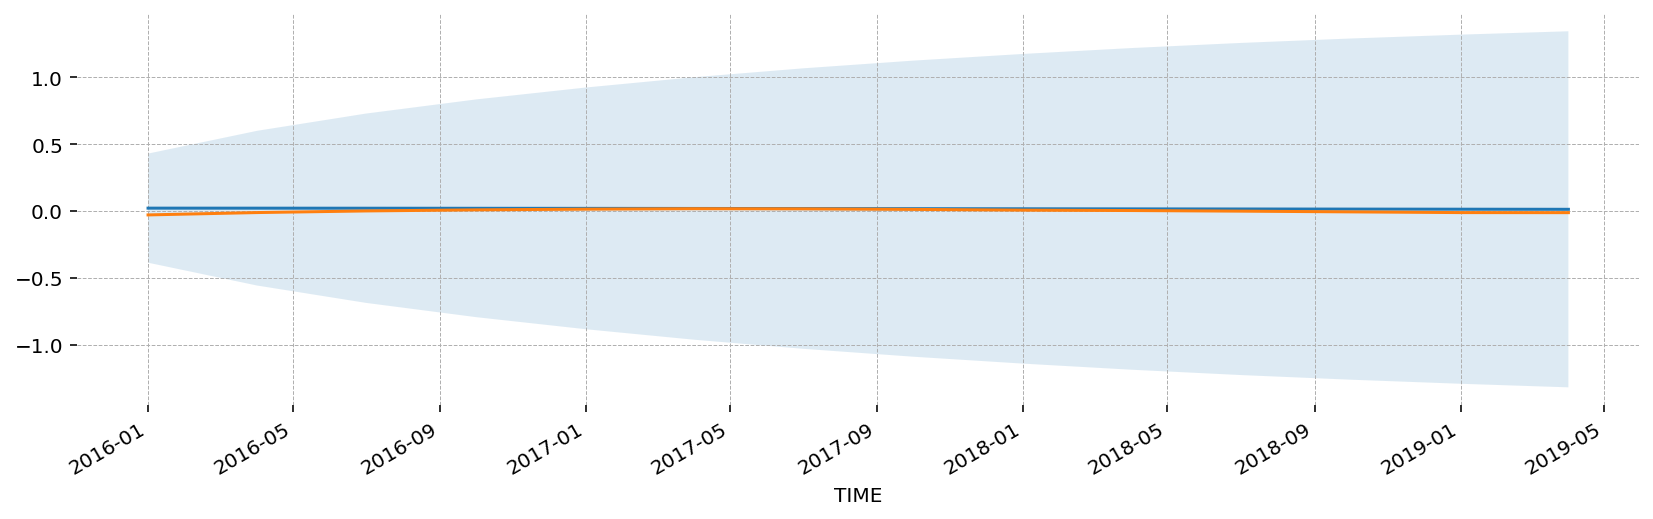

In [66]:
mu = mle_forecast.predicted_mean

# var_pred_mean is the variance, but the 95% CI will be +/- 1.96 * std, so we have to take square root.
sigma = 1.96 * np.sqrt(mle_forecast.var_pred_mean)

fig, ax = plt.subplots()
ax.plot(mu)
ax.fill_between(mu.index, mu - sigma, mu + sigma, alpha=0.15)
test.Y.plot(ax=ax)
plt.show()

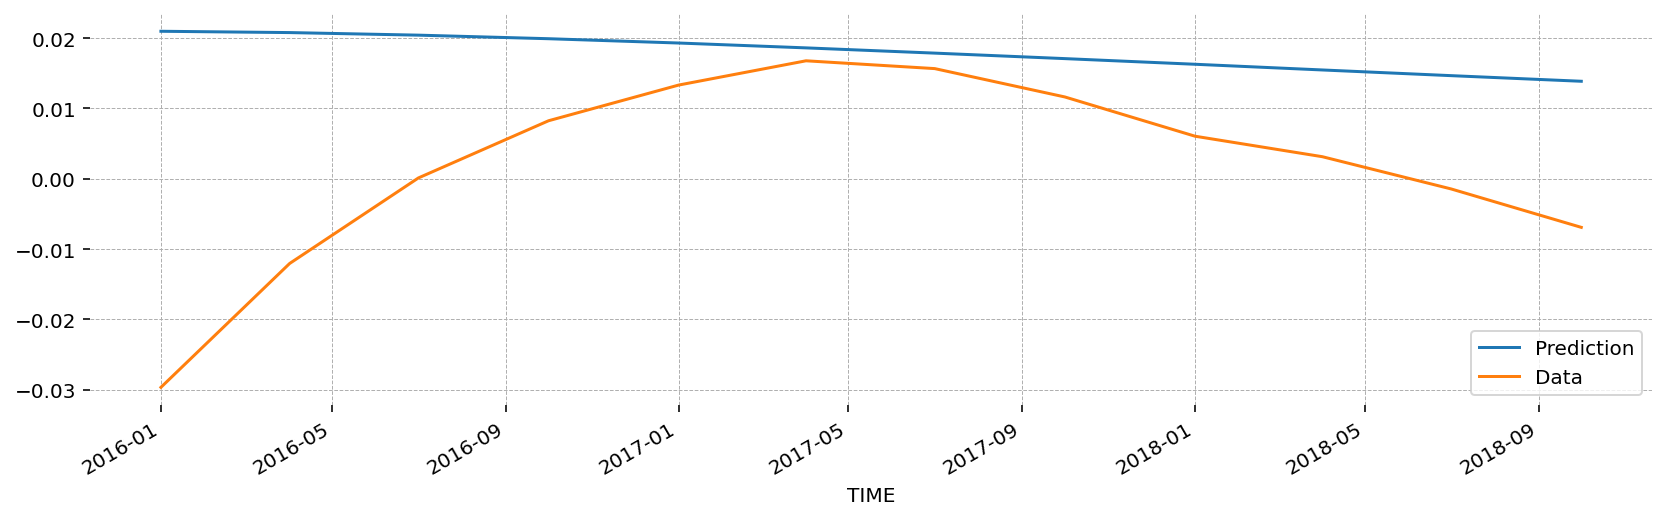

In [67]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

## Adding variables  <a class="anchor" id="section_4_3"></a>

In [68]:
MLEModel = ge.compile_to_statsmodels(rbc)

In [69]:
calibrated_params = {'beta':0.9998, 'alpha':0.262, 'sigma_L':0.52,'sigma_C': 0.0068, 'delta':0.01, 'rho_A': 0.9405}
rbc.free_param_dict.update(calibrated_params)

In [70]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_A':0.85,
    'sigma_C': 0,
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_A':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
    'Y':0.01,
#     'L': 0.05
                    }

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
    'sigma_C': IntervalTransformer(low=0, high=10.0, slope=1),
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
}

mle_mod = MLEModel(train[["Y", 'L']],
                   param_start_dict = param_start_dict,
                   shock_start_dict = shock_start_dict,
                   noise_start_dict = noise_start_dict,
                   param_transforms = param_transforms,
                   shock_transforms=None, 
                   noise_transforms=None, 
                   initialization='stationary')

In [71]:
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=100)

basinhopping step 0: f -1.89379
basinhopping step 1: f -4.18881 trial_f -4.18881 accepted 1  lowest_f -4.18881
found new global minimum on step 1 with function value -4.18881
basinhopping step 2: f -5.26357 trial_f -5.26357 accepted 1  lowest_f -5.26357
found new global minimum on step 2 with function value -5.26357
basinhopping step 3: f -5.26357 trial_f -4.44391 accepted 0  lowest_f -5.26357
basinhopping step 4: f -5.26357 trial_f -2.78034 accepted 0  lowest_f -5.26357
basinhopping step 5: f -4.1582 trial_f -4.1582 accepted 1  lowest_f -5.26357
basinhopping step 6: f -4.20588 trial_f -4.20588 accepted 1  lowest_f -5.26357
basinhopping step 7: f -4.20588 trial_f -1.59557 accepted 0  lowest_f -5.26357
basinhopping step 8: f -4.20588 trial_f -3.6552 accepted 0  lowest_f -5.26357
basinhopping step 9: f -3.15917 trial_f -3.15917 accepted 1  lowest_f -5.26357
basinhopping step 10: f -3.15917 trial_f -2.7304 accepted 0  lowest_f -5.26357
basinhopping step 11: f -2.75947 trial_f -2.75947 acc

basinhopping step 64: f -5.15113 trial_f -1.25647 accepted 0  lowest_f -5.29657
basinhopping step 65: f -5.15113 trial_f -3.96817 accepted 0  lowest_f -5.29657
basinhopping step 66: f -5.38694 trial_f -5.38694 accepted 1  lowest_f -5.38694
found new global minimum on step 66 with function value -5.38694
basinhopping step 67: f -5.26051 trial_f -5.26051 accepted 1  lowest_f -5.38694
basinhopping step 68: f -4.13662 trial_f -4.13662 accepted 1  lowest_f -5.38694
basinhopping step 69: f -5.19354 trial_f -5.19354 accepted 1  lowest_f -5.38694
basinhopping step 70: f -5.19354 trial_f -3.97119 accepted 0  lowest_f -5.38694
basinhopping step 71: f -5.19354 trial_f -3.91827 accepted 0  lowest_f -5.38694
basinhopping step 72: f -5.19354 trial_f -3.90218 accepted 0  lowest_f -5.38694
basinhopping step 73: f -5.19354 trial_f -2.06011 accepted 0  lowest_f -5.38694
basinhopping step 74: f -5.19354 trial_f -2.45533 accepted 0  lowest_f -5.38694
basinhopping step 75: f -5.19354 trial_f -3.10247 accep

In [77]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:             ['Y', 'L']   No. Observations:                   80
Model:                      DSGEModel   Log Likelihood                 154.271
Date:                Wed, 07 Dec 2022   AIC                           -298.542
Time:                        21:11:57   BIC                           -286.632
Sample:                    01-01-1996   HQIC                          -293.767
                         - 10-01-2015                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.8002      2.405      0.333      0.739      -3.913       5.513
sigma_C           6.208e-09      0.002   3.42e-06      1.000      -0.004       0.004
sigma2.epsilon_A     0.0041      0.078      0.052      0.958      -0.148       0.156
sigma2.Y             0.0478      0.132      0.361      0.718      -0.211       0.307
sigma2.L             0.0007      0.011      0.067      0.946      -0.021       0.022
===================================================================================
Ljung-Box (L1) (Q):           74.79, 69.30   Jarque-Bera (JB):           3.36, 2.63
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.19, 0.27
Heteroskedasticity (H):         1.07, 0.86   Skew:                      -0.45, 0.42
Prob(H) (two-sided):            0.87, 0.70   Kurtosis:                   3.46, 3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

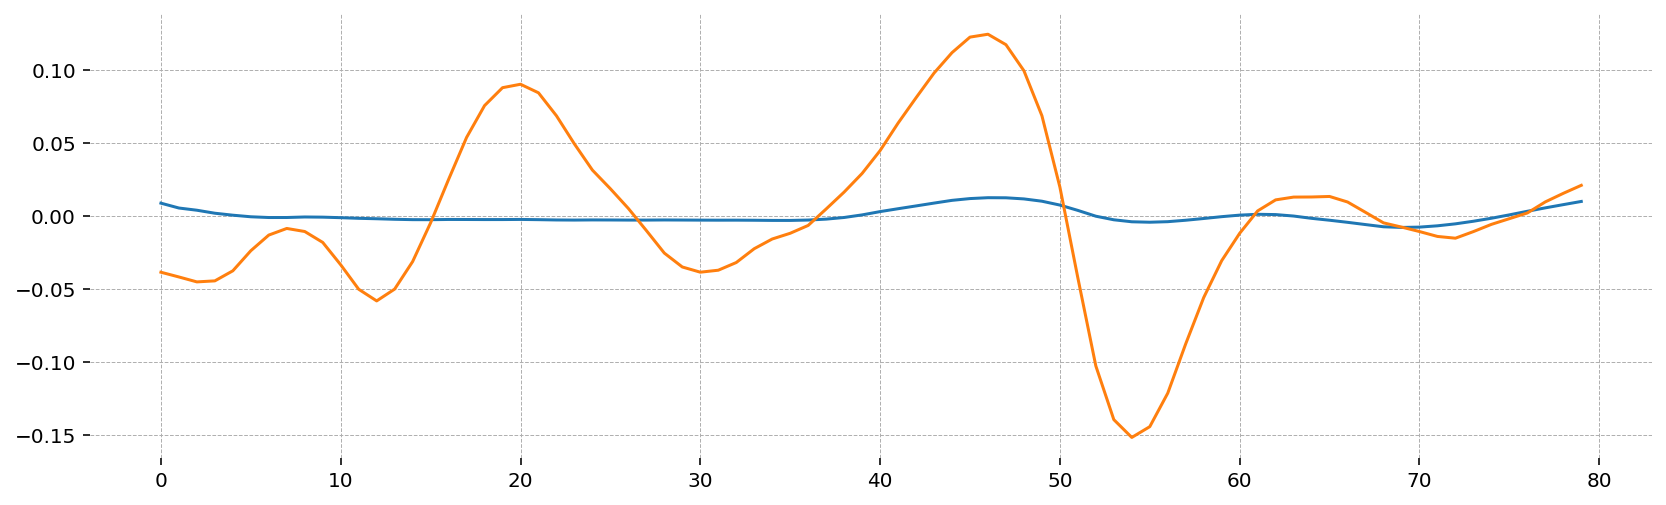

In [78]:
# without any observation noise the 'filter' output should equal the data, why not the case ??
plt.plot(mle_res.filtered_state[0])
plt.plot(train.Y.values)

### MLE Kalman Filter Prediction Plots <a class="anchor" id="section_4_5"></a>

Predictions

The model does not pick-up on much variation in the data. Confidence intervals are rather broad and predicted variations seem random. In magnitude deviations go far beyond the actual data, suggesting that the model has not capture the variance correctly.

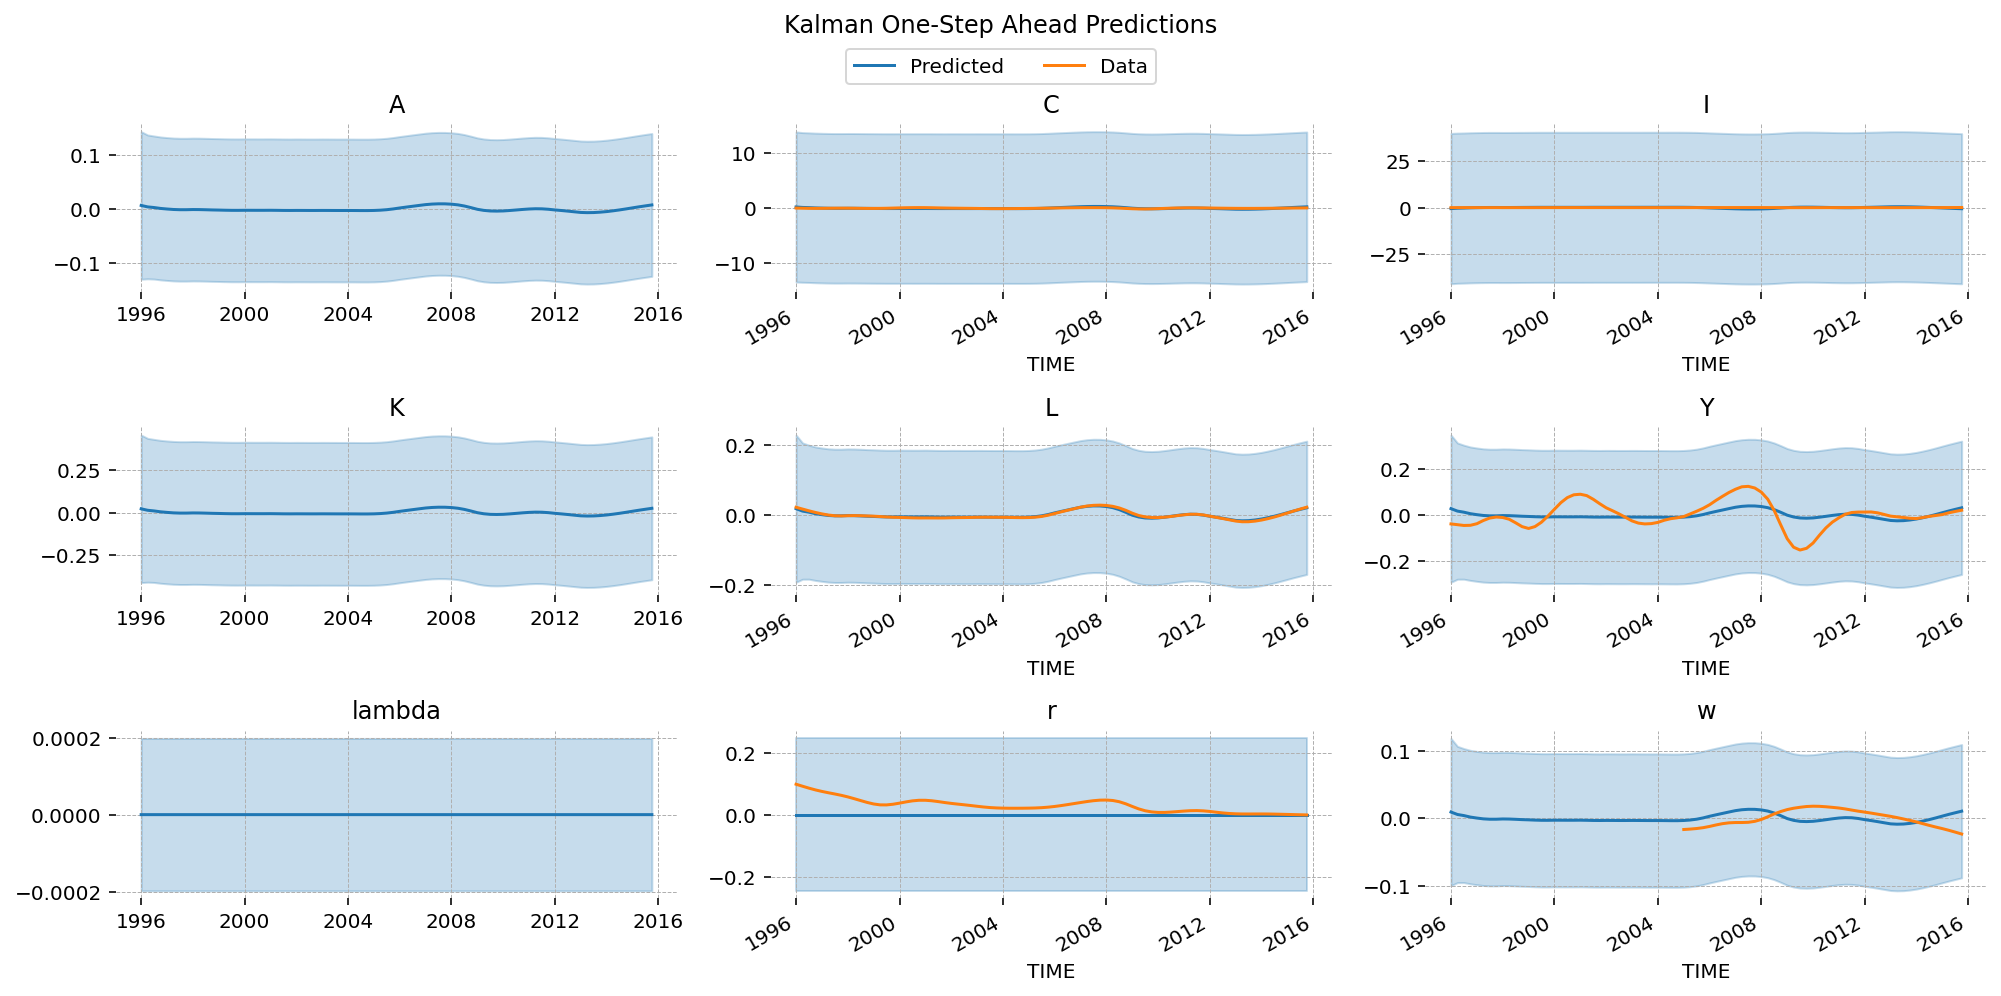

In [79]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

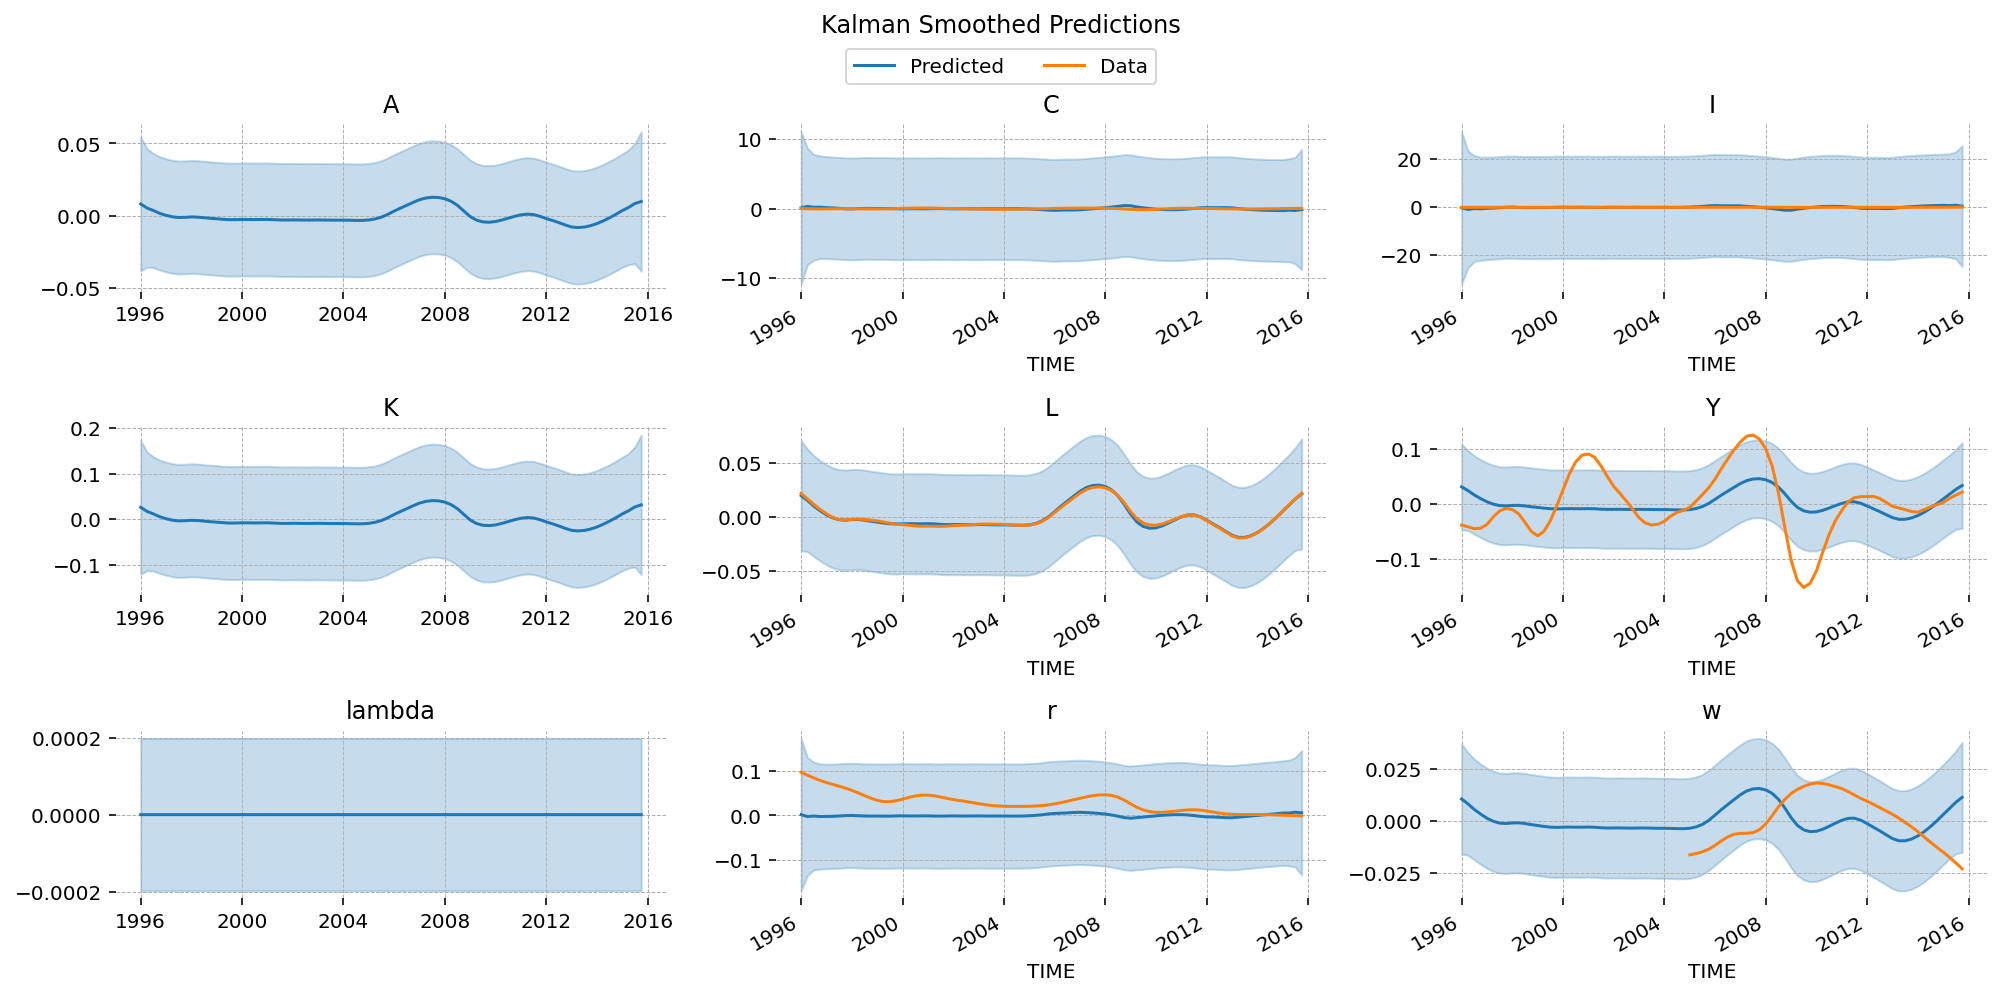

In [80]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="subsection_4_6"></a>

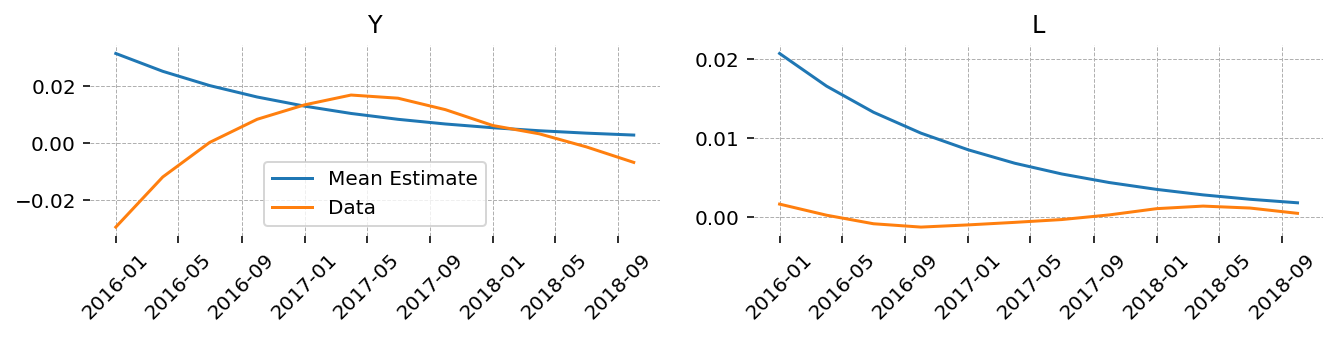

In [85]:
everything_forecast = mle_res.get_forecast(steps=test_size)
mu = everything_forecast.predicted_mean

n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

fig = plt.figure(figsize=(14, 6))
for var, loc in zip(['Y', 'L'], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(test[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

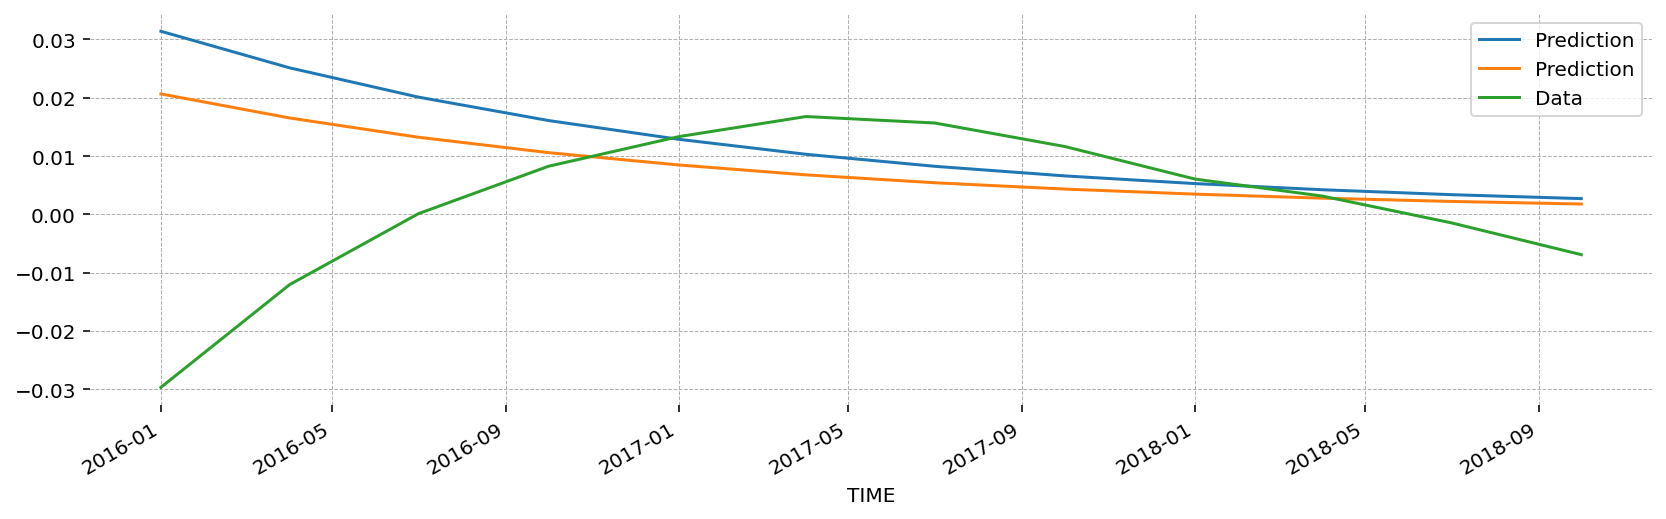

In [86]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

## Final model <a class="anchor" id="section_4_4"></a>

In [102]:
MLEModel = ge.compile_to_statsmodels(rbc)

In [103]:
calibrated_params = {'beta':0.9998, 'alpha':0.262, 'sigma_L':0.52,'sigma_C': 0.0068, 'delta':0.01, 'rho_A': 0.9405}
rbc.free_param_dict.update(calibrated_params)

In [105]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_A':0.85,
#     'sigma_C': 0,
#     'sigma_L': .2,
#     'alpha': .1
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_A':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
#     'Y':0.01,
#     'C':0.02,
#     'L':0.05,
#     'I':0.02,
#     'r':0.03,
#     'w':0.1
                    }

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
#     'sigma_C': IntervalTransformer(low=0, high=3, slope=1),
#     'sigma_L': IntervalTransformer(low=0, high=4, slope=1),
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
#     'alpha':IntervalTransformer(low=0.0001, high=0.99, slope=1)
}

mle_mod = MLEModel(train[["Y", "L", "I", "w"]],
                   param_start_dict = param_start_dict,
                   shock_start_dict = shock_start_dict,
                   noise_start_dict = noise_start_dict,
                   param_transforms = param_transforms,
                   shock_transforms=None, 
                   noise_transforms=None, 
                   initialization='stationary')

In [107]:
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=10)

basinhopping step 0: f 49.941
basinhopping step 1: f 49.941 trial_f 69.6515 accepted 0  lowest_f 49.941
basinhopping step 2: f 1.74679 trial_f 1.74679 accepted 1  lowest_f 1.74679
found new global minimum on step 2 with function value 1.74679
basinhopping step 3: f 1.74679 trial_f 50.9013 accepted 0  lowest_f 1.74679
basinhopping step 4: f 1.74679 trial_f 67.1054 accepted 0  lowest_f 1.74679
basinhopping step 5: f 1.74679 trial_f 52.9038 accepted 0  lowest_f 1.74679
basinhopping step 6: f 1.74679 trial_f 3.18275e+12 accepted 0  lowest_f 1.74679
basinhopping step 7: f 0.735098 trial_f 0.735098 accepted 1  lowest_f 0.735098
found new global minimum on step 7 with function value 0.735098
basinhopping step 8: f 0.735098 trial_f 85.3547 accepted 0  lowest_f 0.735098
basinhopping step 9: f 1.10332 trial_f 1.10332 accepted 1  lowest_f 0.735098
basinhopping step 10: f 1.10332 trial_f 50.1085 accepted 0  lowest_f 0.735098
basinhopping step 11: f 1.10332 trial_f 2.93195e+11 accepted 0  lowest_f 

basinhopping step 63: f 0.717611 trial_f 0.717611 accepted 1  lowest_f 0.626723
basinhopping step 64: f 0.717611 trial_f 43.832 accepted 0  lowest_f 0.626723
basinhopping step 65: f 1.43799 trial_f 1.43799 accepted 1  lowest_f 0.626723
basinhopping step 66: f 1.1257 trial_f 1.1257 accepted 1  lowest_f 0.626723
basinhopping step 67: f 0.616314 trial_f 0.616314 accepted 1  lowest_f 0.616314
found new global minimum on step 67 with function value 0.616314
basinhopping step 68: f 0.691401 trial_f 0.691401 accepted 1  lowest_f 0.616314
basinhopping step 69: f 0.691401 trial_f 45.1553 accepted 0  lowest_f 0.616314
basinhopping step 70: f 0.691401 trial_f 4.60393 accepted 0  lowest_f 0.616314
basinhopping step 71: f 0.691401 trial_f 47.4076 accepted 0  lowest_f 0.616314
basinhopping step 72: f 0.691401 trial_f 2.99935 accepted 0  lowest_f 0.616314
basinhopping step 73: f 0.691401 trial_f 0.99998 accepted 0  lowest_f 0.616314
basinhopping step 74: f 0.691401 trial_f 45.0883 accepted 0  lowest_

In [108]:
mle_res.summary()

C:\Users\LukasGrahl\Documents\GIT\macro_rbc\env_macro_rbc\lib\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
C:\Users\LukasGrahl\Documents\GIT\macro_rbc\env_macro_rbc\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                            
================================================================================
Dep. Variable:     ['Y', 'L', 'I', 'w']   No. Observations:                   80
Model:                        DSGEModel   Log Likelihood                 -64.301
Date:                  Wed, 07 Dec 2022   AIC                            132.601
Time:                          21:22:34   BIC                            137.365
Sample:                      01-01-1996   HQIC                           134.511
                           - 10-01-2015                                         
Covariance Type:                    opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9041   2.65e-17   3.41e+16      0.000       0.904       0.904
sigma2.epsilon_A     0.1997   4.88e-20   4.09e+18      0.000       0.200       0.200
=============================================================================================
Ljung-Box (L1) (Q):     60.93, 0.00, nan, nan   Jarque-Bera (JB):   46.94, 19783.17, nan, nan
Prob(Q):                 0.00, 1.00, nan, nan   Prob(JB):                0.00, 0.00, nan, nan
Heteroskedasticity (H):  0.19, 0.00, nan, nan   Skew:                   -1.39, 8.78, nan, nan
Prob(H) (two-sided):     0.00, 0.00, nan, nan   Kurtosis:               5.51, 78.01, nan, nan
=============================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

### MLE Kalman Filter Prediction Plots <a class="anchor" id="section_4_7"></a>

Predictions

The model does not pick-up on much variation in the data. Confidence intervals are rather broad and predicted variations seem random. In magnitude deviations go far beyond the actual data, suggesting that the model has not capture the variance correctly.

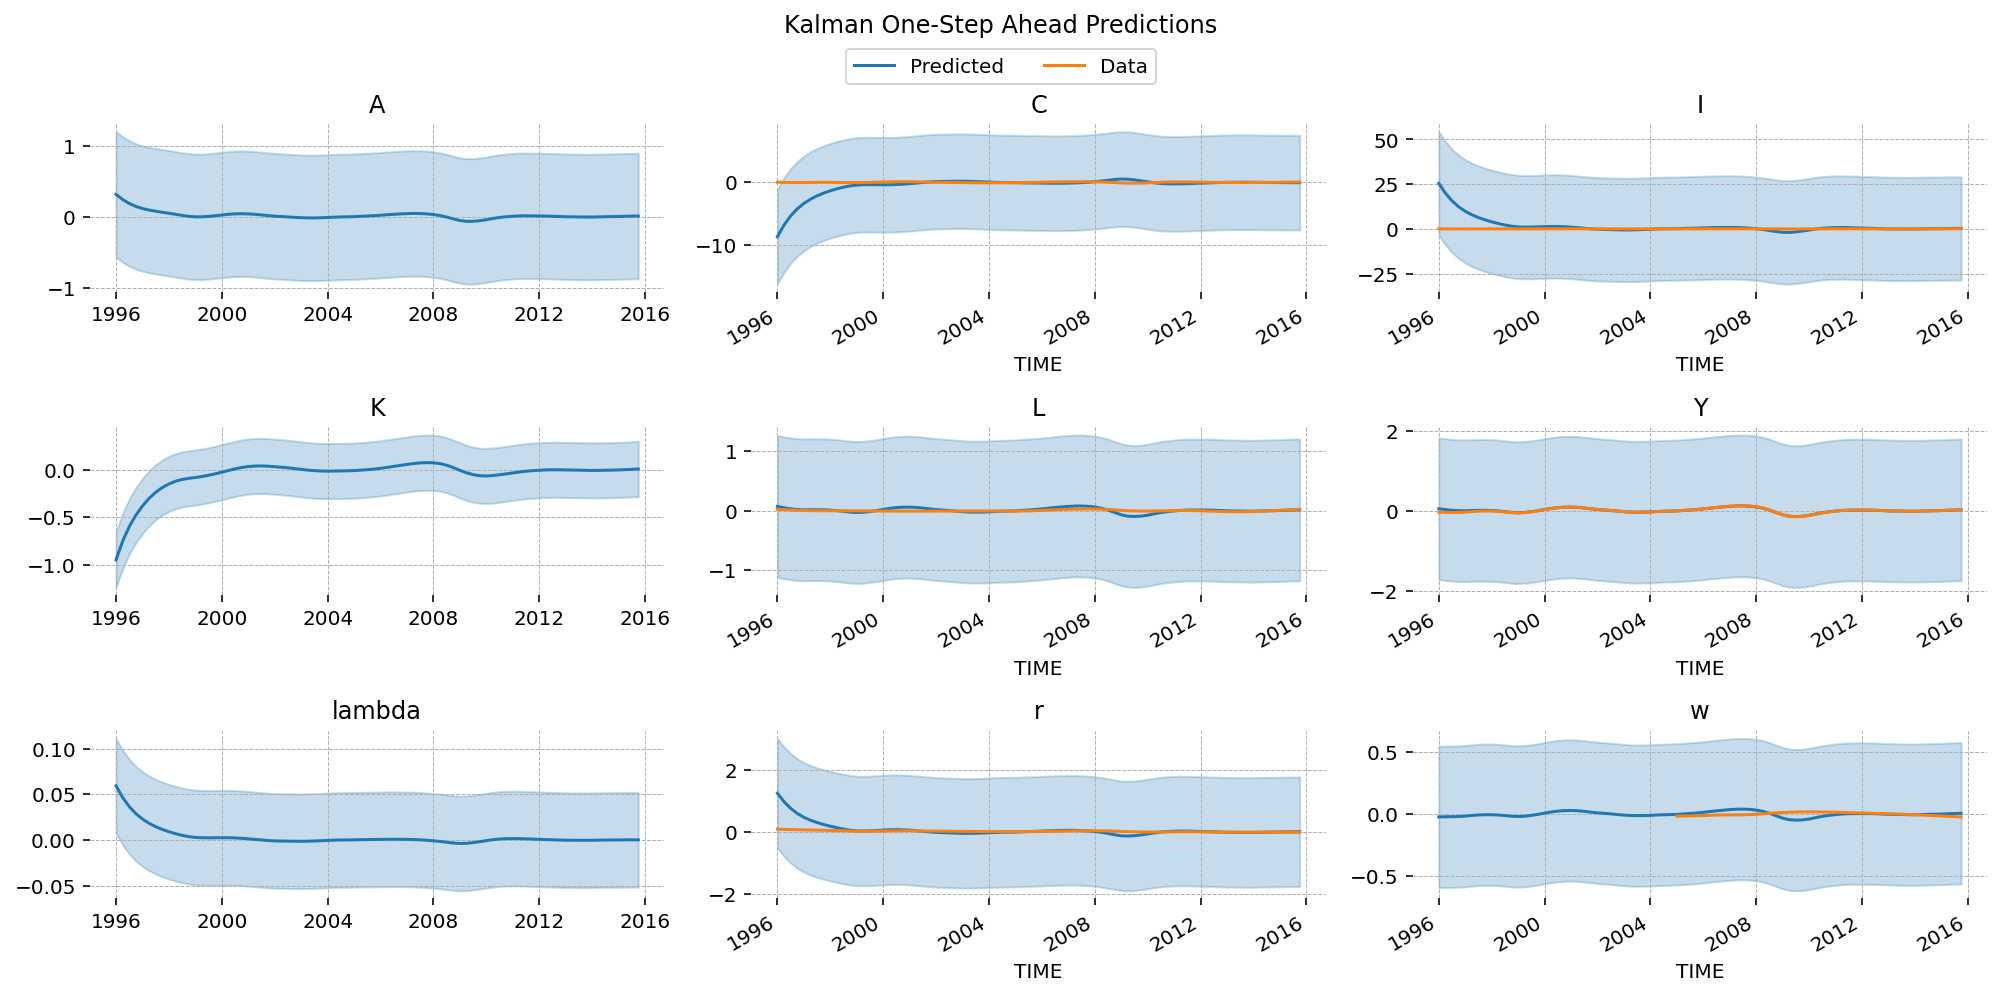

In [110]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

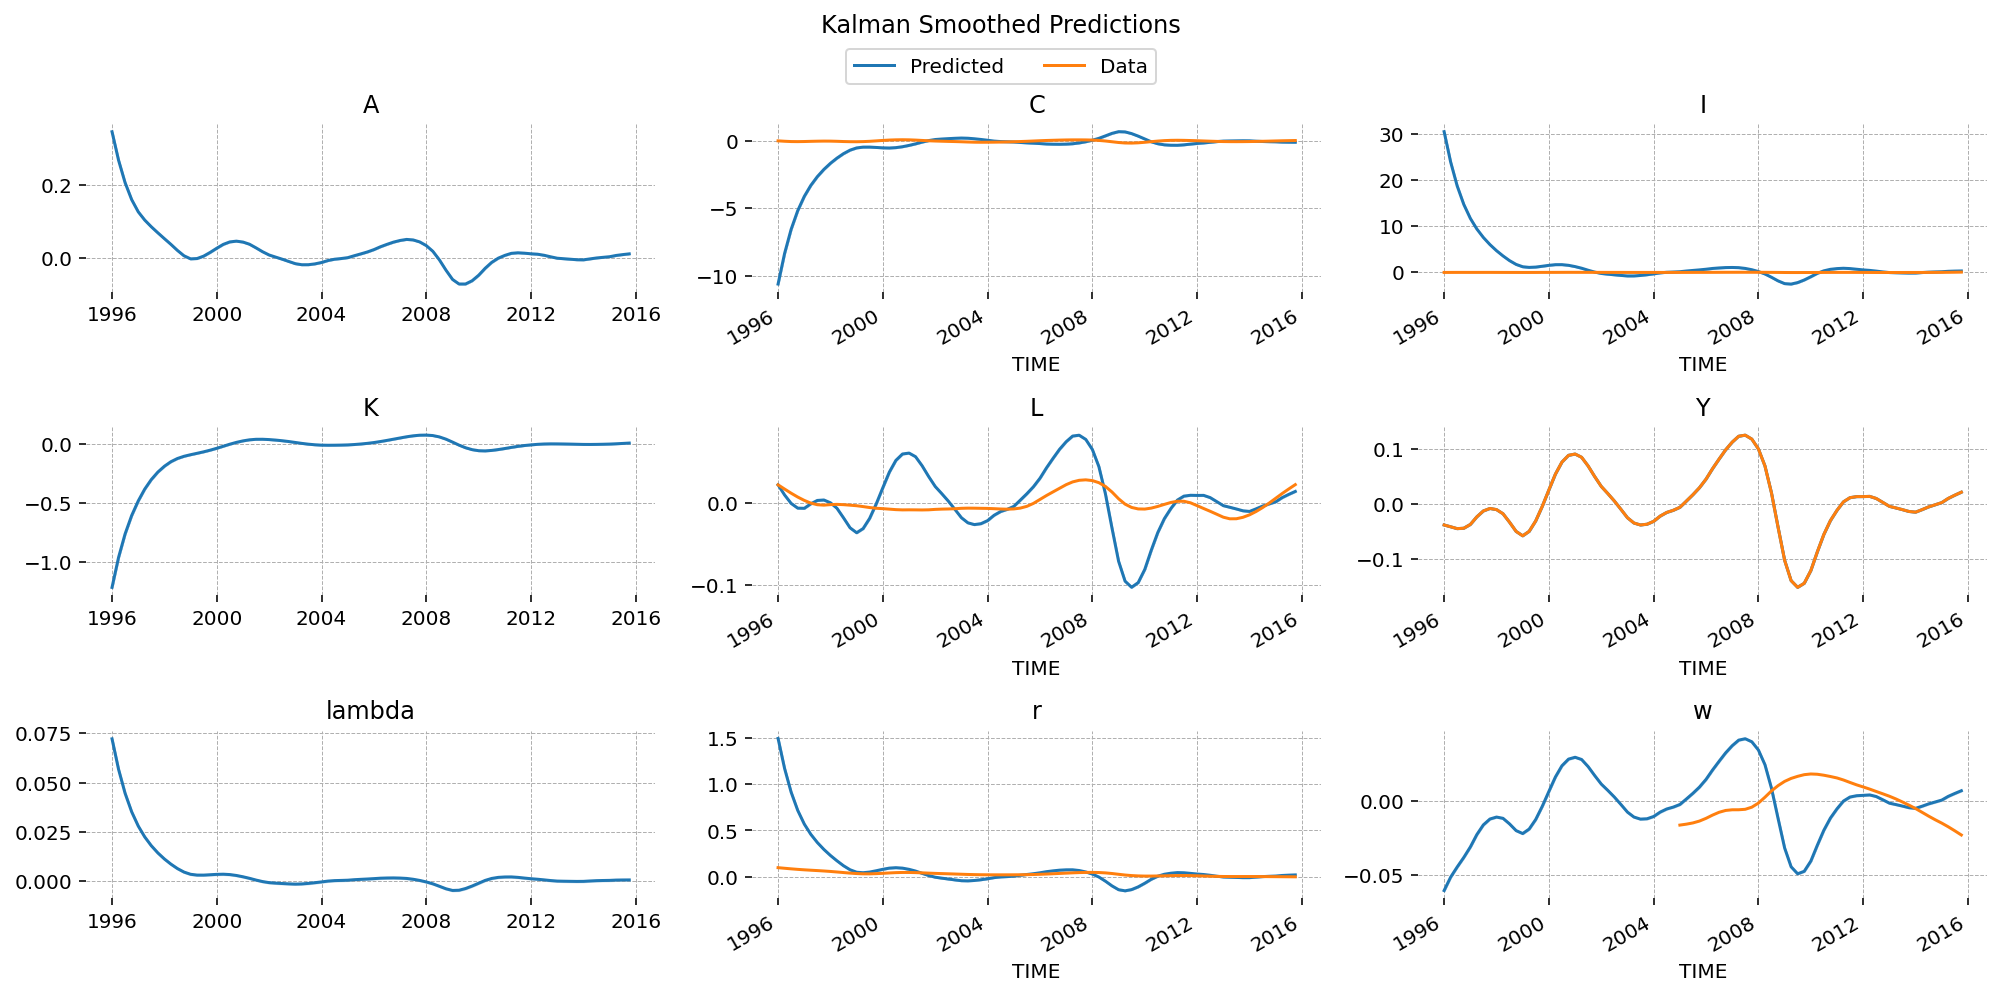

In [111]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="section_4_8"></a>

In [112]:
mle_forecast = mle_res.get_forecast(steps=test_size)

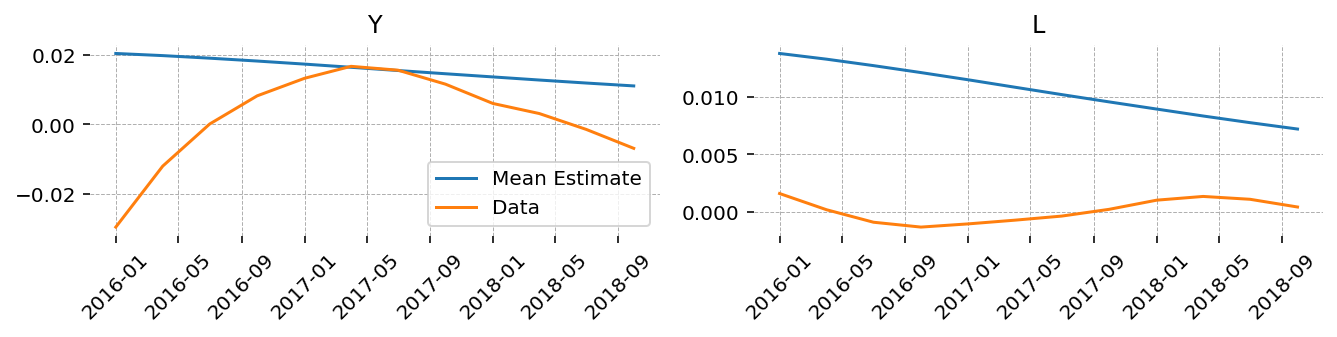

In [113]:
everything_forecast = mle_res.get_forecast(steps=test_size)
mu = everything_forecast.predicted_mean

n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

fig = plt.figure(figsize=(14, 6))
for var, loc in zip(['Y', 'L'], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(test[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

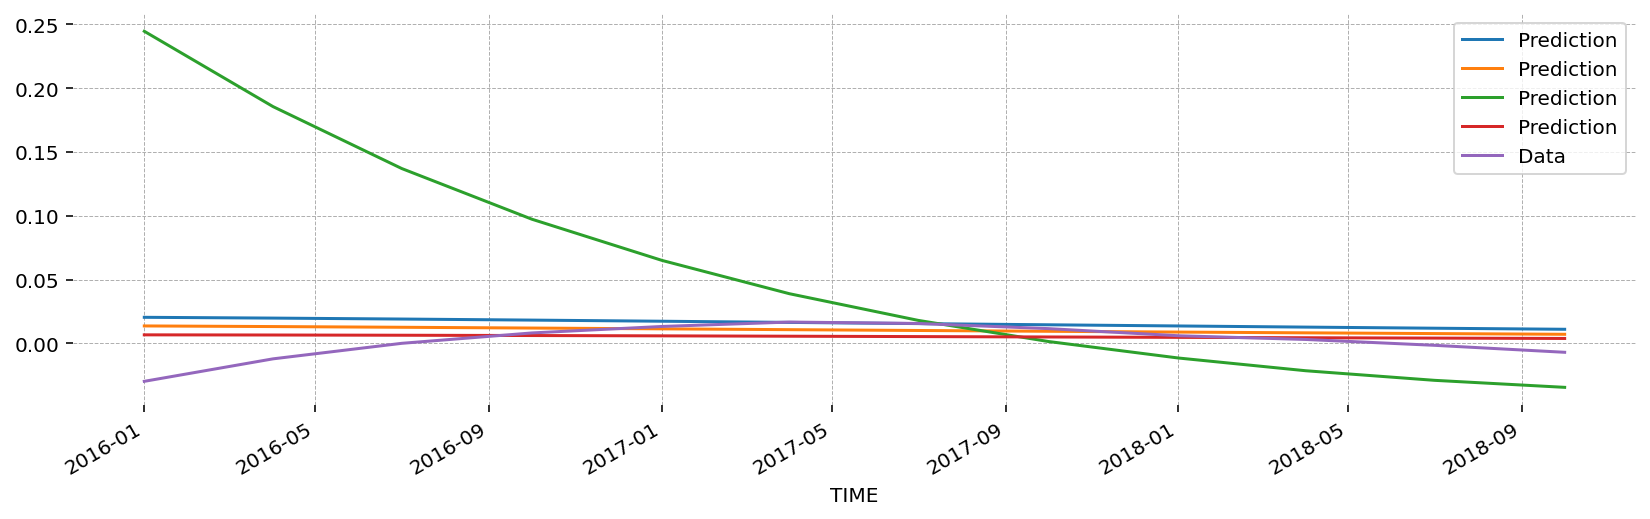

In [114]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

Our model has not correctly captured the notion of an overbooming economy, that evenutally declines. This could be an interpretation of the down-turn in 2017, which has been preceeded by years of recovery and subsquent boom of post 08.

## Impulse response <a class="anchor" id="section_4_5"></a>

In [115]:
irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

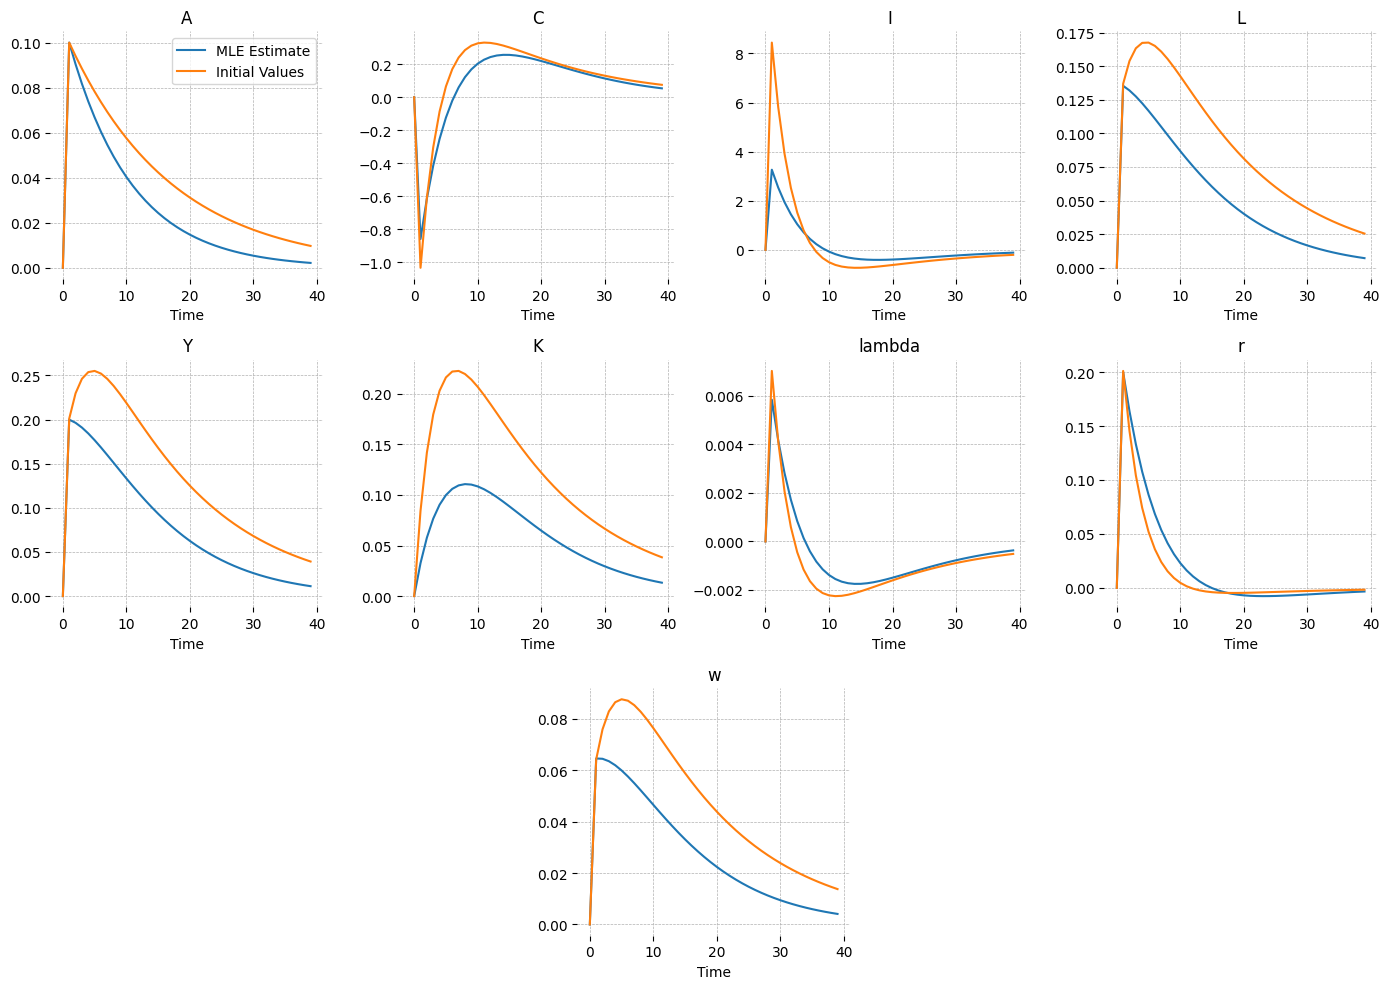

<Figure size 1400x1000 with 0 Axes>

In [116]:
fig = gp.plot_irf(irf.rename(columns={'epsilon_A':'MLE Estimate'}), vars_to_plot=plot_vars)
fig2 = gp.plot_irf(base_irf, vars_to_plot=plot_vars)

for axis, axis2 in zip(fig.axes, fig2.axes):
    line = axis2.get_children()[0]
    axis.plot(line.get_data()[0], line.get_data()[1], color='tab:orange', label='Initial Values')

    
fig.axes[0].legend()
fig2.clear()
fig2.set_visible(False)
plt.show()

### New Steady State <a class="anchor" id="subsection_4_9"></a>

The new steady state has significantly higher capital K_ss and Y_ss as the ex-ante model.

In [117]:
rbc.print_steady_state()

A_ss               1.000
C_ss              11.649
I_ss               4.026
K_ss             402.632
L_ss               4.952
Y_ss              15.675
lambda_ss          0.983
r_ss               0.010
w_ss               2.336


In [119]:
mle_mod.param_names

['rho_A', 'sigma2.epsilon_A']